# Хакатон R1 Телеком & Яндекс Практикум
## Тема: машинное обучение и анализ данных, предсказание поведения клиента 
### Данные:
Для каждой пары 'id' + 'period' собрано более 2500 признаков
Названия признаков интерпретируются следующим образом:

<модуль><номер признака><глубина агрегации>_<тип>

Если признак построен как агрегат (например сумма за период), то указывается <глубина агрегации> в
месяцах, в противном случае ставится 0. Также, в качестве <глубина агрегации> может быть запись вида
'3d6', что указывает на отношение агрегата за 3 месяца к агрегату за 6 месяцев.

Различные типы признаков (<тип>) описаны ниже:

- flg - флаг (значение 1 или 0)
- ctg - категориальный признак
- num - числовой признак
- dt - дата
- cnt -количество
- sum -сумма
- avg - среднее
- sumpct -персентиль по сумме
- part - доля
## Бизнес-задача: 
Разработка модели склонности (бинарной классификации) к покупке клиентом оборудования после коммуникации с ним в одном из каналов. Оценка происходит по метрике ROC_AUC
### Примечание:
В нашей работе код является полностью воспроизводимым, если запускать его на 1 машине, на которой достаточно мощностей. На наших машинах можностей недостаточно, поэтому мы прибегали к итеративному воспроизведению ячеек с сохранением промежуточных результатов после того как машина выдавала ошибку памяти. Мы пробовали уменьшать признаки , но в рамках соревнования самая лучшая метрика у нас была с полным набором признаков. 
### План действий:
- загрузка и анализ данных
- поиска аномалий, выбросов и прочих особенностей
- создание новых признаков и отбор текущих
- предобработка и подготовка данных для анализа
- построение лучшей модели и подбор гиперпараметров
- тестирование различных гипотез для достижения лучшей метрики
- анализ важности признаков для лучшей модели
- итоговый вывод
## Загрузка и анализ данных 

In [1]:
#подключаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier

In [2]:
#загружаем датасет
df = pd.read_parquet('dataset_train.parquet', engine='fastparquet')
df.head(5)

,id,period,channel_name,target,markers_0_1_cnt,markers_1_1_cnt,markers_2_1_cnt,markers_3_1_cnt,markers_4_1_cnt,markers_5_1_cnt,...,autopay_1_1_flg,autopay_3_1_flg,communication_availability_67_1_flg,social_dem_1_0_flg,social_dem_2_0_flg,social_dem_3_0_flg,social_dem_4_0_flg,user_active_35_1_flg,tariff_plans_26_src_id,communication_availability_69_1_flg
0,1702673,202208,5,0,-0.149534,-0.096585,-0.400870,-0.362458,0.302917,-0.324892,...,-1,-1,0,-1,-1,-1,-1,1,-1,1
1,1177940,202210,5,0,-0.149534,-0.096585,0.196468,-0.362458,0.092276,-0.324892,...,-1,-1,0,-1,-1,-1,-1,0,-1,1
2,1212244,202210,5,1,-0.149534,-0.096585,-0.102201,0.911996,0.724200,0.445189,...,-1,-1,0,1,0,0,0,0,-1,1
3,1354105,202212,3,0,-0.149534,-0.096585,-0.400870,-0.362458,1.145482,-0.324892,...,-1,-1,0,1,0,0,1,0,-1,1
4,1091598,202211,1,0,-0.149534,-0.096585,0.196468,-0.362458,0.934841,-0.324892,...,-1,-1,0,1,0,0,1,0,-1,1


In [4]:
df.shape

(702086, 2780)

Датасет состоит из 702086 строк и 2780 столбцов

In [6]:
df.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 2780 columns):
 #     Column                               Dtype  
---    ------                               -----  
 0     id                                   object 
 1     period                               int32  
 2     channel_name                         object 
 3     target                               int32  
 4     markers_0_1_cnt                      float64
 5     markers_1_1_cnt                      float64
 6     markers_2_1_cnt                      float64
 7     markers_3_1_cnt                      float64
 8     markers_4_1_cnt                      float64
 9     markers_5_1_cnt                      float64
 10    markers_6_1_cnt                      float64
 11    markers_7_1_cnt                      float64
 12    markers_8_1_cnt                      float64
 13    markers_9_1_cnt                      float64
 14    markers_10_1_cnt                     float64
 15

In [3]:
#проверим датасет на пропущенные значения
missing_values = df.isna().sum()
print(missing_values.to_string())

id                                          0
period                                      0
channel_name                                0
target                                      0
markers_0_1_cnt                         30822
markers_1_1_cnt                         30822
markers_2_1_cnt                         30822
markers_3_1_cnt                         30822
markers_4_1_cnt                         30822
markers_5_1_cnt                         30822
markers_6_1_cnt                         30822
markers_7_1_cnt                         30822
markers_8_1_cnt                         30822
markers_9_1_cnt                         30822
markers_10_1_cnt                        30822
markers_11_1_cnt                        30822
markers_12_1_cnt                        30822
markers_13_1_cnt                        30822
markers_14_1_cnt                        30822
markers_15_1_cnt                        30822
markers_16_1_cnt                        30822
markers_17_1_cnt                  

В датасете имеется большое количество признаков с пропущенными значениями

In [3]:
#оцениваем распределение целевого класса
df['target'].value_counts()

target
0    696617
1      5469
Name: count, dtype: int64

Имеется дисбаланс классов

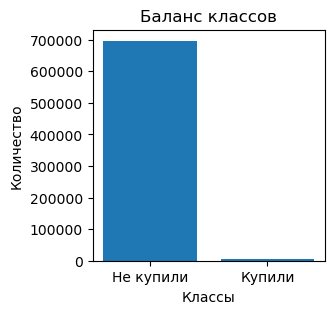

In [4]:
#построим гистограмму, отображающую баланс классов
class_counts = [df['target'].value_counts()[0], df['target'].value_counts()[1]]
class_labels = ['Не купили', 'Купили']

plt.figure(figsize=(3, 3))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Баланс классов')

plt.show()

Мы видим дизбаланс классов. Это надо будет учитывать при дальнейшем обучении модели. 

In [5]:
#оценим распределение каналов связи
df['channel_name'].value_counts()

channel_name
5    221058
3    209022
4    135852
1    131566
2      4588
Name: count, dtype: int64

Мы видим, что данных со 2-м каналом наименьшее количетво.

In [5]:
#проверим имеются ли дубликаты
df.duplicated().sum()

0

Полные дубликаты отсутствуют

Вывод:

- проведена загрузка и обработка данных, получена следующая информация

- датасет состоит из 702086 строк и 2780 столбцов;

- имеется большое количество признаков с пропущенными значениями;

- имеется дисбаланс классов;

- данных со 2-м каналом наименьшее количетво;

- полные дубликаты отсутствуют.

## Поиск аномалий, выбросов и прочих особенностей

In [7]:
std_dev = df.std()

#зададим порог для высокого стандартного отклонения (например, 2.0)
threshold = 2.0

#выберем признаки, у которых стандартное отклонение больше порога
high_std_dev_features = std_dev[std_dev > threshold].index

print("Признаки с высоким стандартным отклонением:")
print(high_std_dev_features)

Признаки с высоким стандартным отклонением:
Index(['period', 'materials_details_0_1_ctg', 'materials_details_1_1_ctg',
       'user_lifetime_0_1_ctg', 'tariff_plans_12_1_ctg',
       'tariff_plans_16_1_ctg', 'tariff_plans_18_1_ctg',
       'tariff_plans_23_1_ctg', 'materials_details_13_1_ctg', 'cities_1_0_ctg',
       'materials_details_14_1_ctg', 'materials_details_15_1_ctg',
       'info_house_10_0_ctg', 'cities_2_0_ctg', 'tariff_plans_25_1_ctg',
       'communication_availability_10_1_ctg', 'tariff_plans_13_src_id',
       'tariff_plans_15_src_id', 'communication_availability_40_1_ctg',
       'tariff_plans_17_src_id', 'tariff_plans_19_src_id',
       'tariff_plans_24_src_id', 'communication_availability_56_1_ctg',
       'tariff_plans_26_src_id'],
      dtype='object')


/var/folders/_n/b8p745b91pb1cf581xnktc6c0000gn/T/ipykernel_895/1173720043.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_dev = df.std()


In [13]:
#посмотрим статистическую информацию для нескольких столбцов
selected_columns = ['materials_details_0_1_ctg', 'materials_details_1_1_ctg',
       'user_lifetime_0_1_ctg', 'tariff_plans_12_1_ctg',
       'tariff_plans_16_1_ctg', 'tariff_plans_18_1_ctg',
       'tariff_plans_23_1_ctg', 'materials_details_13_1_ctg']

selected_columns_description = df[selected_columns].describe()

print(selected_columns_description)

       materials_details_0_1_ctg  materials_details_1_1_ctg  \
count              702086.000000              702086.000000   
mean                    6.785872                   1.392969   
std                    33.646201                   5.649698   
min                     0.000000                   0.000000   
25%                     1.000000                   1.000000   
50%                     1.000000                   1.000000   
75%                     1.000000                   1.000000   
max                   303.000000                  86.000000   

       user_lifetime_0_1_ctg  tariff_plans_12_1_ctg  tariff_plans_16_1_ctg  \
count          702086.000000          702086.000000          702086.000000   
mean                3.501345              47.844687             734.546120   
std                 5.263654              18.214400             518.923038   
min                 0.000000               0.000000               0.000000   
25%                 0.000000              

In [9]:
selected_columns_2 = ['cities_1_0_ctg',
       'materials_details_14_1_ctg', 'materials_details_15_1_ctg',
       'info_house_10_0_ctg', 'cities_2_0_ctg',
       'communication_availability_10_1_ctg', 'tariff_plans_13_src_id',
       'tariff_plans_15_src_id']

selected_columns_description = df[selected_columns_2].describe()

print(selected_columns_description)

       cities_1_0_ctg  materials_details_14_1_ctg  materials_details_15_1_ctg  \
count   702086.000000               702086.000000               702086.000000   
mean        18.795492                   25.869563                  527.167074   
std         10.339154                   66.034173                 1266.124219   
min          0.000000                    0.000000                    0.000000   
25%          9.000000                    0.000000                    0.000000   
50%         22.000000                    0.000000                    0.000000   
75%         26.000000                    0.000000                    0.000000   
max         37.000000                  317.000000                 4998.000000   

       info_house_10_0_ctg  cities_2_0_ctg  \
count        702086.000000    702086.00000   
mean         346774.441715        28.15326   
std          203236.237157        15.01254   
min               0.000000         0.00000   
25%          170930.250000        15.000

In [10]:
selected_columns_3 = ['communication_availability_40_1_ctg',
       'tariff_plans_17_src_id', 'tariff_plans_19_src_id',
       'tariff_plans_24_src_id', 'communication_availability_56_1_ctg']
selected_columns_description = df[selected_columns_3].describe()

print(selected_columns_description)

       communication_availability_40_1_ctg  tariff_plans_17_src_id  \
count                        702086.000000           702086.000000   
mean                              1.924340            28289.348044   
std                               2.120687            33383.682066   
min                              -1.000000               -1.000000   
25%                               0.000000               -1.000000   
50%                               2.000000               -1.000000   
75%                               4.000000            53628.000000   
max                               5.000000           114540.000000   

       tariff_plans_19_src_id  tariff_plans_24_src_id  \
count           702086.000000           702086.000000   
mean             60700.114218            13857.289618   
std              22220.519884            25357.757713   
min                 -1.000000               -1.000000   
25%              45407.000000               -1.000000   
50%              55085.0000

У нас возникла гипотеза, что если промаркировать данные с выбросами по 99 квантилю мы могли бы создать признак

In [1]:
'''
def create_above_quantile_columns(df, quantile=0.99):
    new_columns = []
    for column in df.select_dtypes(include='number'):
        new_column = f'{column}_above_{quantile}_quantile'
        new_columns.append((new_column, (df[column] >= df[column].quantile(quantile)).astype(int)))
    new_columns_df = pd.concat([column_data[1] for column_data in new_columns], axis=1)
    df = pd.concat([df, new_columns_df], axis=1)
    return df
df = create_above_quantile_columns(df, quantile=0.99)
'''

"\ndef create_above_quantile_columns(df, quantile=0.99):\n    new_columns = []\n    for column in df.select_dtypes(include='number'):\n        new_column = f'{column}_above_{quantile}_quantile'\n        new_columns.append((new_column, (df[column] >= df[column].quantile(quantile)).astype(int)))\n    new_columns_df = pd.concat([column_data[1] for column_data in new_columns], axis=1)\n    df = pd.concat([df, new_columns_df], axis=1)\n    return df\ndf = create_above_quantile_columns(df, quantile=0.99)\n"

К сожалению, машина не выдерживает новых признаков, нет возможности проверить гипотезу

Вывод:
- проведена работа по поиску аномалий, выбросов и прочих особенностей;
- поставленную гипотезу не удалось реализовать по причине недостаточных мощностей.

## Предобработка и подготовка данных 

Мы имеем слишком большой файл, необходимо придумать как эффективно обработать его частями. Мы обратили внимание, что весь файл разделен на каналы. 

Протестируем гипотезу, насколько хороший мы получим результат, если найдем по отдельности значения предсказаний на кросс-валидации для каждого канала по отдельности, а затем найдем среднее арифметическое их предиктов. 

Создадим 5 срезов для каждого канала по отдельности.

In [ ]:
# df = df.drop(feature_list, axis=1)

In [3]:
df1 = df.query('channel_name=="1"')

In [17]:
df2 = df.query('channel_name=="2"')

In [19]:
df3 = df.query('channel_name=="3"')

In [7]:
df4 = df.query('channel_name=="4"')

In [3]:
df5 = df.query('channel_name=="5"')

Выделим целевой признак и признаки для обучения для каждого канала.

In [4]:
target1 = df1['target']
features1 = df1.drop('target', axis=1)

In [18]:
target2 = df2['target']
features2 = df2.drop('target', axis=1)

In [20]:
target3 = df3['target']
features3 = df3.drop('target', axis=1)

In [8]:
target4 = df4['target']
features4 = df4.drop('target', axis=1)

In [4]:
target5 = df5['target']
features5 = df5.drop('target', axis=1)

Вывод:
- данные полготовлены для дальнейшего обучения;
- датасет разделен на 5 отдельных датасетов, выделен целевой признак и признаки для обучения по каждому каналу.

# Построение лучшей модели и подбор гиперпараметров

Исходя из описания задачи и рекомендованного стэка мы приняли решение работать с Catboost так как у каждого участника был с ним опыт, он поддерживает видеокарту, а так же это было для нас разумно в условиях ограниченности времени. 

## Модель CatBoost

Ниже мы построим 5 моделей CatBoost для каждого канала по отдельности, а затем сохраним значения для каждого значения в файл. Разделение на каналы - это гипотеза к которой мы прибели после анализа важности признаков. Самый важный призна был показан как канал, который влияет на результат. В то же время канал номер 2 имеет очень мало строк для такого предсказания, возможно поэтому у него низкий скор и поэтому мы не будем его использовать в итоговом исследовании. 

Важное замечание, срезы данных и применение моделей проводится итеративно, поэтому ячейки кода не имеют точный порядок, так как когда ядро тетрадки умирает, мы имеет предыдущие сохраненные данные , которые мы не обновляем и переходим к следующей модели для следующего класса. 

Подбор гиперпараметров осуществляется не случайно. В связи с дизбалансом классов мы должны учитывать что модель хорошо будет интерпретировать признаки класса 0 и хуже класса 1. Мы так же тестировать параметр важности классов соотвественно. 

In [5]:
%%time

model = CatBoostClassifier(task_type='GPU', random_state=12345)

class_weights=[50]
grid_space={
    'learning_rate': [0.01],
    'verbose': [False],
    'l2_leaf_reg': [6.5],
    'depth': [4],
    'iterations': [1600],
    'class_weights': [[1, weight] for weight in class_weights]
}

grid1 = GridSearchCV(model, scoring='roc_auc', param_grid=grid_space , cv=20)

grid1.fit(features1, target1)

print('Лучшие гиперпараметры: ', grid1.best_params_)
print('Результат roc_auc: ', grid1.best_score_)

Лучшие гиперпараметры:  {'class_weights': [1, 50], 'depth': 4, 'iterations': 1600, 'l2_leaf_reg': 6.5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.7063279290029693
CPU times: total: 17min 6s
Wall time: 5min 3s


In [ ]:
%%time

model = CatBoostClassifier(task_type='GPU', random_state=12345, class_weights=[1, 10], verbose=False)

grid_space={
}

grid2 = GridSearchCV(model, scoring='roc_auc', param_grid=grid_space , cv=10)

grid2.fit(features2, target2)

print('Лучшие гиперпараметры: ', grid2.best_params_)
print('Результат roc_auc: ', grid2.best_score_)

In [33]:
%%time

model = CatBoostClassifier(task_type='GPU', random_state=12345)
class_weights=[50]
grid_space={
    'learning_rate': [0.01],
    'verbose': [False],
    'l2_leaf_reg': [6.5],
    'depth': [4],
    'iterations': [1600],
    'class_weights': [[1, weight] for weight in class_weights]
}

grid3 = GridSearchCV(model, scoring='roc_auc', param_grid=grid_space, cv=20)
grid3.fit(features3, target3)

print('Лучшие гиперпараметры: ', grid3.best_params_)
print('Результат roc_auc: ', grid3.best_score_)

Лучшие гиперпараметры:  {'class_weights': [1, 50], 'depth': 4, 'iterations': 1600, 'l2_leaf_reg': 6.5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.6857984303333052
CPU times: total: 22min 24s
Wall time: 6min 8s


In [9]:
%%time

model = CatBoostClassifier(task_type='GPU', random_state=12345)
class_weights=[50]
grid_space={
    'learning_rate': [0.01],
    'verbose': [False],
    'l2_leaf_reg': [6.5],
    'depth': [4],
    'iterations': [1600],
    'class_weights': [[1, weight] for weight in class_weights]
}

grid4 = GridSearchCV(model, scoring='roc_auc', param_grid=grid_space , cv=20)

grid4.fit(features4, target4)

print('Лучшие гиперпараметры: ', grid4.best_params_)
print('Результат roc_auc: ', grid4.best_score_)

Лучшие гиперпараметры:  {'class_weights': [1, 50], 'depth': 4, 'iterations': 1600, 'l2_leaf_reg': 6.5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.7153259296029731
CPU times: total: 18min 5s
Wall time: 5min 29s


In [5]:
%%time

model = CatBoostClassifier(task_type='GPU', random_state=12345)
class_weights=[50]
grid_space={
    'learning_rate': [0.01],
    'verbose': [False],
    'l2_leaf_reg': [6.5],
    'depth': [4],
    'iterations': [1600],
    'class_weights': [[1, weight] for weight in class_weights]
}

grid5 = GridSearchCV(model, scoring='roc_auc', param_grid=grid_space , cv=20)

grid5.fit(features5, target5)

print('Лучшие гиперпараметры: ', grid5.best_params_)
print('Результат roc_auc: ', grid5.best_score_)

Лучшие гиперпараметры:  {'class_weights': [1, 50], 'depth': 4, 'iterations': 1600, 'l2_leaf_reg': 6.5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.7006648075158157
CPU times: total: 22min 52s
Wall time: 6min 15s


Посмотрим важность признаков

In [15]:
importances = grid5.best_estimator_.feature_importances_
feature_names = features5.columns

# Создание DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                  Feature  Importance
2645   communication_availability_3_1_flg    4.127813
2678  communication_availability_30_1_flg    3.125417
1900           materials_details_16_1_ctg    2.468254
1562                   info_house_5_0_num    1.366568
687                     markers_706_1_cnt    1.335661
...                                   ...         ...
1129           spas_symptoms_iptv_5_1_cnt    0.000000
1128           spas_symptoms_iptv_4_1_cnt    0.000000
1127           spas_symptoms_iptv_3_1_cnt    0.000000
1126           spas_symptoms_iptv_2_1_cnt    0.000000
2778  communication_availability_69_1_flg    0.000000

[2779 rows x 2 columns]


Не так много важны признаков. Попробуем протестировать удаление некоторых 

На всех наших машинах падает датасет, поэтому решено произвести по каждому каналу отдельно свой анализ. Ниже мы сохранили базовые значения полученные на кросс-валидации без подбора гиперпараметров. 
Мы обратили внимание, что удаление признаков значимость которых менее 0.01 все равно ведет к ухуджению метрики на лидерборде. Поэтому мы решили не удалять признаки. 

Ниже приведенные значения для cv=10

In [14]:
'''
--------------------------------------
channel_name=="1":
class_weights=[1, 10]
cv=10
Лучшие гиперпараметры:  {}
Результат roc_auc:  0.6807295206584433
CPU times: total: 8min 31s
Wall time: 2min 28s
--------------------------------------
channel_name=="2":
class_weights=[1, 10]
cv=10
Лучшие гиперпараметры:  {}
Результат roc_auc:  0.626319948302558
CPU times: total: 7min 38s
Wall time: 6min 39s
--------------------------------------
channel_name=="3":
class_weights=[1, 10]
cv=10
Лучшие гиперпараметры:  {}
Результат roc_auc:  0.6829141032849207
CPU times: total: 12min 6s
Wall time: 4min 41s
--------------------------------------
channel_name=="4":
class_weights=[1, 10]
cv=10
Лучшие гиперпараметры:  {}
Результат roc_auc:  0.7056899715591748
CPU times: total: 9min 18s
Wall time: 2min 57s
--------------------------------------
channel_name=="5":
class_weights=[1, 10]
cv=10
Лучшие гиперпараметры:  {}
Результат roc_auc:  0.6932523062683549
CPU times: total: 10min 58s
Wall time: 3min 3s
--------------------------------------    
'''

'\n--------------------------------------\nchannel_name=="1":\nclass_weights=[1, 10]\ncv=10\nЛучшие гиперпараметры:  {}\nРезультат roc_auc:  0.6807295206584433\nCPU times: total: 8min 31s\nWall time: 2min 28s\n--------------------------------------\nchannel_name=="2":\nclass_weights=[1, 10]\ncv=10\nЛучшие гиперпараметры:  {}\nРезультат roc_auc:  0.626319948302558\nCPU times: total: 7min 38s\nWall time: 6min 39s\n--------------------------------------\nchannel_name=="3":\nclass_weights=[1, 10]\ncv=10\nЛучшие гиперпараметры:  {}\nРезультат roc_auc:  0.6829141032849207\nCPU times: total: 12min 6s\nWall time: 4min 41s\n--------------------------------------\nchannel_name=="4":\nclass_weights=[1, 10]\ncv=10\nЛучшие гиперпараметры:  {}\nРезультат roc_auc:  0.7056899715591748\nCPU times: total: 9min 18s\nWall time: 2min 57s\n--------------------------------------\nchannel_name=="5":\nclass_weights=[1, 10]\ncv=10\nЛучшие гиперпараметры:  {}\nРезультат roc_auc:  0.6932523062683549\nCPU times: t

Подберем гиперпараметры для каждого класса по отдельности. Таким образом мы рассчитываем, что это даст лучшее качество для всего датасета на тестовой выборке. 

Под катбустом сохраним результаты подбора гиперпараметров, где были изменения. Сохранили лишь некоторые из них, так как тестов было кратно больше.

In [8]:
'''
--------------------------------------
class_weights=[1, 10]
cv=3
Лучшие гиперпараметры:  {}
Результат roc_auc:  0.6780626180507427
CPU times: total: 4min 16s
Wall time: 1min 43s
--------------------------------------
class_weights=[1, 10]
cv=3
Лучшие гиперпараметры:  {'l2_leaf_reg': 3, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.6798144023852849
CPU times: total: 31min
Wall time: 9min 48s
--------------------------------------
class_weights=[1, 10]
cv=3
Лучшие гиперпараметры:  {'l2_leaf_reg': 5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.6800202984547736
CPU times: total: 12min 29s
Wall time: 4min 16s
--------------------------------------
class_weights=[1, 30]
cv=3
Лучшие гиперпараметры:  {'depth': 5, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.6801667830410132
CPU times: total: 8min 1s
Wall time: 2min 33s
--------------------------------------
cv=3
Лучшие гиперпараметры:  {'class_weights': [1, 30], 'depth': 5, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.6837079029861917
CPU times: total: 10min 59s
Wall time: 3min 24s
--------------------------------------
cv=3
Лучшие гиперпараметры:  {'class_weights': [1, 50], 'depth': 5, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.6835942498094316
CPU times: total: 9min 16s
Wall time: 2min 31s
--------------------------------------
cv=3
Лучшие гиперпараметры:  {'depth': 5, 'iterations': 1100, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.6841016982002209
CPU times: total: 12min 8s
Wall time: 4min 2s
--------------------------------------
cv=10
Лучшие гиперпараметры:  {'depth': 5, 'iterations': 1100, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.6852051074877414
CPU times: total: 14min 33s
Wall time: 4min 39s
--------------------------------------
cv=20
Лучшие гиперпараметры:  {'depth': 5, 'iterations': 1100, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'verbose': False}
Результат roc_auc:  0.6845958302209879
CPU times: total: 28min 33s
Wall time: 9min 4s
--------------------------------------
'''

"\n--------------------------------------\nclass_weights=[1, 10]\ncv=3\nЛучшие гиперпараметры:  {}\nРезультат roc_auc:  0.6780626180507427\nCPU times: total: 4min 16s\nWall time: 1min 43s\n--------------------------------------\nclass_weights=[1, 10]\ncv=3\nЛучшие гиперпараметры:  {'l2_leaf_reg': 3, 'learning_rate': 0.01, 'verbose': False}\nРезультат roc_auc:  0.6798144023852849\nCPU times: total: 31min\nWall time: 9min 48s\n--------------------------------------\nclass_weights=[1, 10]\ncv=3\nЛучшие гиперпараметры:  {'l2_leaf_reg': 5, 'learning_rate': 0.01, 'verbose': False}\nРезультат roc_auc:  0.6800202984547736\nCPU times: total: 12min 29s\nWall time: 4min 16s\n--------------------------------------\nclass_weights=[1, 30]\ncv=3\nЛучшие гиперпараметры:  {'depth': 5, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'verbose': False}\nРезультат roc_auc:  0.6801667830410132\nCPU times: total: 8min 1s\nWall time: 2min 33s\n--------------------------------------\ncv=3\nЛучшие гиперпараметры:  {'c

Промежуточный вывод:

Мы проверили гипотезу о получении лучшего результата путем разбивки и оценки данных по классам. Мы выделили классы и оценили по отдельности. Мы получили следующие результаты:
- класс 2 имеет самый низкий результ. Общая метрика без него на лидерборде лучше
- среднее арифметическое вроятностей 4 лучших каналов на кросс-валидации из 20 фолдов, по всем признакм дает лучший результат на Kaggle: 0.6654 

Вывод:
- обучено 5 моделей CatBoost для каждого канала по отдельности;
- сохранены значения для каждого значения в отдельный файл;
- проверена гипотеза о получении лучшего результата путем разбивки и оценки данных по классам. Мы выделили классы и оценили по отдельности;
- класс 2 имеет самый низкий результ;
- среднее арифметическое вроятностей 4 лучших каналов на кросс-валидации из 20 фолдов, по всем признакм дает лучший результат на Kaggle: 0.6654 

# Тестирование различных гипотез

### Проверим гипотезу. 
Возьмем 100 и 700 отобранных признаков и попробуем рассчитать для них метрику roc_auc на кросс-валидации.

In [2]:
#загружаем датасет заново
df = pd.read_parquet('dataset_train.parquet', engine='fastparquet')

In [ ]:
# признаки для удаления с низкой важностью 700 признаков
# feature_list = ['markers_367_1_cnt', 'spas_symptoms_int_159_1_cnt', 'markers_385_1_cnt', 'spas_symptoms_agr_87_3_std', 'markers_97_1_cnt', 'campaigns_370_1_part', 'markers_413_1_cnt', 'spas_symptoms_agr_182_3_avg', 'markers_414_1_cnt', 'spas_symptoms_agr_244_3_sum', 'campaigns_284_6_part', 'campaigns_2_6_cnt', 'issues_121_1_sum', 'movix_app_visits_79_1_cnt', 'markers_615_1_cnt', 'vas_details_11_6_sum', 'issues_123_6_sum', 'user_devices_19_1_cnt', 'spas_symptoms_int_10_1_cnt', 'spas_symptoms_agr_263_1_avg', 'autopay_0_0_ctg', 'markers_131_1_cnt', 'markers_212_1_cnt', 'spas_symptoms_ott_96_1_cnt', 'movix_app_visits_13_1_cnt', 'spas_symptoms_int_133_1_cnt', 'spas_symptoms_agr_173_6_avg', 'spas_symptoms_int_89_1_cnt', 'movix_channels_71_6_sum', 'user_devices_29_1_cnt', 'markers_623_1_cnt', 'issues_119_3_sum', 'campaigns_16_1_sum', 'markers_674_1_cnt', 'vas_details_19_1d3_mean', 'vas_details_2_6_sum', 'movix_app_visits_37_1_cnt', 'spas_symptoms_int_19_1_cnt', 'markers_696_1_cnt', 'markers_899_1_cnt', 'user_active_22_0_dt', 'markers_647_1_cnt', 'campaigns_129_1_part', 'campaigns_396_6_sum', 'markers_829_1_cnt', 'movix_app_visits_43_1_part', 'vas_details_58_6_mean', 'markers_590_1_cnt', 'markers_426_1_cnt', 'campaigns_282_1_sum', 'movix_app_visits_8_1_part', 'spas_symptoms_agr_242_3_avg', 'issues_6_1_sum', 'spas_symptoms_ott_95_1_cnt', 'markers_398_1_cnt', 'spas_symptoms_agr_259_6_sum', 'spas_symptoms_int_42_1_cnt', 'markers_252_1_cnt', 'campaigns_402_3_sum', 'markers_699_1_cnt', 'migrant_0_1_flg', 'spas_symptoms_agr_193_1_sum', 'markers_793_1_cnt', 'markers_313_1_cnt', 'markers_751_1_cnt', 'campaigns_108_1_part', 'spas_symptoms_int_149_1_cnt', 'markers_459_1_cnt', 'issues_148_6_sum', 'movix_channels_40_3_avg', 'markers_378_1_cnt', 'tariff_plans_4_1_num', 'markers_42_1_cnt', 'markers_373_1_cnt', 'markers_562_1_cnt', 'spas_symptoms_agr_207_3_std', 'movix_app_visits_44_1_cnt', 'markers_302_1_cnt', 'markers_85_1_cnt', 'spas_symptoms_agr_144_1_std', 'movix_channels_69_1_sum', 'movix_channels_90_1_sum', 'spas_symptoms_agr_220_3_sum', 'markers_785_1_cnt', 'spas_symptoms_int_95_1_cnt', 'markers_831_1_cnt', 'movix_channels_87_1_sum', 'markers_761_1_cnt', 'spas_symptoms_int_29_1_cnt', 'campaigns_380_1_part', 'campaigns_35_1_sum', 'spas_symptoms_agr_223_6_sum', 'markers_712_1_cnt', 'markers_290_1_cnt', 'smarttv_age_1_1_avg', 'markers_569_1_cnt', 'markers_519_1_cnt', 'markers_371_1_cnt', 'markers_282_1_cnt', 'markers_50_1_cnt', 'issues_25_3_sum', 'campaigns_360_1_sum', 'spas_symptoms_int_9_1_cnt', 'spas_symptoms_agr_37_1_sum', 'spas_symptoms_agr_221_6_avg', 'movix_channels_13_3_avg', 'markers_351_1_cnt', 'markers_445_1_cnt', 'spas_symptoms_iptv_10_1_cnt', 'traffic_details_47_3_sum', 'charges_details_30_1_sum', 'spas_symptoms_agr_236_12_avg', 'markers_114_1_cnt', 'user_active_19_1_flg', 'campaigns_323_6_part', 'vas_details_49_3_cnt', 'movix_channels_16_3_avg', 'spas_symptoms_agr_7_6_sum', 'markers_744_1_cnt', 'markers_532_1_cnt', 'issues_3_1_sum', 'markers_896_1_cnt', 'spas_symptoms_int_13_1_cnt', 'spas_symptoms_agr_249_12_std', 'markers_172_1_cnt', 'domru_site_215_1_cnt', 'spas_symptoms_agr_51_3_std', 'markers_621_1_cnt', 'spas_symptoms_agr_284_12_avg', 'issues_139_6_sum', 'movix_app_visits_50_1_cnt', 'arpu_0_1_sum', 'markers_54_1_cnt', 'markers_658_1_cnt', 'movix_channels_60_1_sum', 'issues_98_1_sum', 'campaigns_398_1_sum', 'markers_442_1_cnt', 'traffic_details_64_3_std', 'spas_symptoms_agr_91_6_sum', 'spas_symptoms_ott_53_1_cnt', 'markers_737_1_cnt', 'spas_symptoms_ott_84_1_cnt', 'campaigns_379_1_cnt', 'markers_303_1_cnt', 'markers_755_1_cnt', 'save_team_answers_35_1_cnt', 'markers_916_1_cnt', 'movix_channels_20_6_avg', 'spas_symptoms_agr_80_12_avg', 'markers_887_1_cnt', 'markers_466_1_cnt', 'user_devices_6_1_cnt', 'spas_symptoms_tv_23_1_cnt', 'markers_337_1_cnt', 'cities_1_0_ctg', 'campaigns_109_1_sum', 'spas_symptoms_int_66_1_cnt', 'markers_828_1_cnt', 'markers_154_1_cnt', 'markers_225_1_cnt', 'movix_app_visits_28_1_part', 'vas_details_20_1d6_mean', 'campaigns_159_1_sum', 'markers_945_1_cnt', 'markers_743_1_cnt', 'movix_channels_41_6_avg', 'markers_861_1_cnt', 'spas_symptoms_agr_75_3_std', 'markers_889_1_cnt', 'markers_47_1_cnt', 'markers_331_1_cnt', 'markers_81_1_cnt', 'payments_details_22_3_cnt', 'movix_app_visits_74_1_cnt', 'markers_918_1_cnt', 'spas_symptoms_agr_169_1_sum', 'spas_symptoms_int_119_1_cnt', 'spas_symptoms_int_11_1_cnt', 'campaigns_261_3_part', 'payments_details_4_3_cnt', 'markers_156_1_cnt', 'spas_symptoms_ott_23_1_cnt', 'spas_symptoms_int_99_1_cnt', 'spas_symptoms_agr_69_12_std', 'markers_56_1_cnt', 'markers_35_1_cnt', 'markers_493_1_cnt', 'markers_461_1_cnt', 'markers_70_1_cnt', 'campaigns_173_1_part', 'charges_details_9_1_sum', 'spas_symptoms_int_135_1_cnt', 'markers_823_1_cnt', 'spas_symptoms_agr_271_6_sum', 'campaigns_358_1_sum', 'movix_channels_77_6_sum', 'campaigns_60_1_part', 'spas_symptoms_agr_100_3_sum', 'markers_463_1_cnt', 'markers_407_1_cnt', 'user_devices_14_1_cnt', 'markers_98_1_cnt', 'spas_symptoms_ott_68_1_cnt', 'markers_18_1_cnt', 'spas_symptoms_agr_243_3_std', 'markers_192_1_cnt', 'markers_926_1_cnt', 'markers_807_1_cnt', 'markers_883_1_cnt', 'markers_336_1_cnt', 'spas_symptoms_agr_195_3_std', 'spas_symptoms_iptv_6_1_cnt', 'movix_channels_102_1_sum', 'save_team_answers_27_1_cnt', 'spas_symptoms_int_107_1_cnt', 'markers_240_1_cnt', 'movix_channels_35_6_avg', 'markers_913_1_cnt', 'spas_symptoms_tv_9_1_cnt', 'movix_channels_54_3_avg', 'movix_app_visits_41_1_cnt', 'markers_256_1_cnt', 'markers_391_1_cnt', 'spas_symptoms_agr_137_6_avg', 'spas_symptoms_int_51_1_cnt', 'campaigns_81_1_sum', 'spas_symptoms_ott_3_1_cnt', 'markers_927_1_cnt', 'movix_app_visits_71_1_cnt', 'movix_app_visits_24_1_cnt', 'movix_app_visits_5_1_cnt', 'issues_57_1_sum', 'movix_channels_72_1_sum', 'spas_symptoms_agr_6_6_std', 'markers_94_1_cnt', 'movix_app_visits_27_1_cnt', 'campaigns_375_6_part', 'user_devices_8_1_cnt', 'markers_725_1_cnt', 'markers_354_1_cnt', 'markers_552_1_cnt', 'spas_symptoms_agr_247_6_sum', 'markers_231_1_cnt', 'markers_129_1_cnt', 'spas_symptoms_agr_16_3_sum', 'movix_channels_97_3_sum', 'markers_518_1_cnt', 'user_devices_0_1_cnt', 'markers_511_1_cnt', 'markers_607_1_cnt', 'markers_539_1_cnt', 'markers_924_1_cnt', 'markers_51_1_cnt', 'campaigns_326_3_part', 'markers_340_1_cnt', 'vas_details_0_1_sum', 'movix_channels_4_1d3_part', 'movix_app_visits_47_1_part', 'markers_910_1_cnt', 'spas_symptoms_int_65_1_cnt', 'save_team_answers_17_1_cnt', 'markers_860_1_cnt', 'deact_react_2_1_ctg', 'markers_377_1_cnt', 'markers_96_1_cnt', 'spas_symptoms_int_102_1_cnt', 'markers_914_1_cnt', 'markers_498_1_cnt', 'markers_662_1_cnt', 'movix_app_visits_25_1_cnt', 'markers_38_1_cnt', 'movix_channels_39_1_avg', 'movix_channels_0_1_avg', 'markers_566_1_cnt', 'spas_symptoms_agr_107_1_avg', 'markers_565_1_cnt', 'movix_app_visits_75_1_cnt', 'movix_channels_46_3_avg', 'user_devices_27_1_cnt', 'movix_app_visits_46_1_cnt', 'markers_890_1_cnt', 'markers_842_1_cnt', 'spas_symptoms_agr_270_6_std', 'spas_symptoms_tv_20_1_cnt', 'markers_389_1_cnt', 'campaigns_59_6_part', 'markers_429_1_cnt', 'spas_symptoms_agr_97_1_sum', 'markers_477_1_cnt', 'markers_226_1_cnt', 'markers_545_1_cnt', 'markers_659_1_cnt', 'spas_symptoms_int_57_1_cnt', 'issues_115_1_sum', 'spas_symptoms_int_16_1_cnt', 'markers_66_1_cnt', 'communication_availability_61_1_flg', 'markers_138_1_cnt', 'markers_440_1_cnt', 'spas_symptoms_agr_42_6_std', 'user_devices_1_1_cnt', 'markers_237_1_cnt', 'markers_22_1_cnt', 'campaigns_346_3_sum', 'markers_942_1_cnt', 'campaigns_66_3_part', 'spas_symptoms_agr_192_1_std', 'markers_229_1_cnt', 'spas_symptoms_agr_77_6_avg', 'issues_30_1_sum', 'markers_121_1_cnt', 'campaigns_33_6_part', 'movix_channels_99_1_sum', 'movix_channels_32_6_avg', 'movix_channels_70_3_sum', 'markers_11_1_cnt', 'spas_symptoms_agr_50_3_avg', 'markers_588_1_cnt', 'issues_4_3_sum', 'markers_650_1_cnt', 'movix_channels_48_1_avg', 'markers_136_1_cnt', 'markers_735_1_cnt', 'markers_700_1_cnt', 'markers_824_1_cnt', 'movix_app_visits_54_1_cnt', 'payments_details_26_6_cnt', 'markers_522_1_cnt', 'campaigns_356_1_sum', 'markers_826_1_cnt', 'spas_symptoms_agr_33_12_std', 'spas_symptoms_int_75_1_cnt', 'markers_360_1_cnt', 'markers_326_1_cnt', 'markers_557_1_cnt', 'movix_app_visits_3_1_cnt', 'markers_297_1_cnt', 'spas_symptoms_agr_183_3_std', 'markers_619_1_cnt', 'spas_symptoms_agr_133_1_sum', 'spas_symptoms_agr_239_1_avg', 'markers_931_1_cnt', 'materials_details_24_1_cnt', 'markers_263_1_cnt', 'markers_65_1_cnt', 'spas_symptoms_agr_98_3_avg', 'markers_875_1_cnt', 'spas_symptoms_int_151_1_cnt', 'tariff_plans_6_1_num', 'markers_365_1_cnt', 'issues_147_3_sum', 'markers_833_1_cnt', 'markers_308_1_cnt', 'markers_873_1_cnt', 'spas_symptoms_int_43_1_cnt', 'markers_687_1_cnt', 'markers_408_1_cnt', 'spas_symptoms_int_26_1_cnt', 'markers_835_1_cnt', 'spas_symptoms_agr_61_1_sum', 'issues_84_1_sum', 'markers_620_1_cnt', 'markers_412_1_cnt', 'movix_channels_103_3_sum', 'spas_symptoms_agr_39_3_std', 'issues_73_1_sum', 'markers_609_1_cnt', 'movix_app_visits_29_1_cnt', 'movix_channels_92_6_sum', 'markers_335_1_cnt', 'user_devices_16_1_cnt', 'markers_934_1_cnt', 'markers_876_1_cnt', 'movix_channels_91_3_sum', 'movix_channels_6_3_part', 'movix_channels_101_6_sum', 'campaigns_65_1_sum', 'markers_665_1_cnt', 'markers_825_1_cnt', 'markers_660_1_cnt', 'communication_availability_62_1_flg', 'spas_symptoms_tv_22_1_cnt', 'markers_203_1_cnt', 'issues_27_1_sum', 'spas_symptoms_agr_122_3_avg', 'markers_296_1_cnt', 'issues_45_1_sum', 'markers_794_1_cnt', 'spas_symptoms_agr_196_3_sum', 'markers_174_1_cnt', 'markers_863_1_cnt', 'spas_symptoms_agr_78_6_std', 'movix_channels_68_6_sum', 'markers_784_1_cnt', 'movix_channels_47_6_avg', 'markers_485_1_cnt', 'movix_channels_88_3_sum', 'campaigns_64_1_part', 'markers_270_1_cnt', 'markers_759_1_cnt', 'spas_symptoms_agr_88_3_sum', 'charges_details_0_1_sum', 'spas_symptoms_int_110_1_cnt', 'movix_channels_15_1_avg', 'spas_symptoms_int_12_1_cnt', 'markers_791_1_cnt', 'movix_app_visits_33_1_cnt', 'markers_521_1_cnt', 'spas_symptoms_ott_38_1_cnt', 'save_team_answers_39_1_cnt', 'campaigns_63_6_part', 'movix_channels_17_6_avg', 'spas_symptoms_int_128_1_cnt', 'spas_symptoms_ott_117_1_cnt', 'markers_612_1_cnt', 'spas_symptoms_agr_170_3_avg', 'campaigns_62_3_part', 'issues_33_1_sum', 'tariff_plans_14_1_ctg', 'markers_284_1_cnt', 'spas_symptoms_agr_189_12_std', 'markers_415_1_cnt', 'markers_678_1_cnt', 'movix_channels_51_1_avg', 'movix_app_visits_35_1_cnt', 'issues_12_1_sum', 'markers_877_1_cnt', 'issues_42_1_sum', 'spas_symptoms_agr_258_6_std', 'markers_844_1_cnt', 'spas_symptoms_agr_34_12_sum', 'markers_88_1_cnt', 'markers_366_1_cnt', 'spas_symptoms_int_138_1_cnt', 'markers_37_1_cnt', 'markers_898_1_cnt', 'campaigns_29_1_sum', 'markers_439_1_cnt', 'spas_symptoms_agr_185_6_avg', 'markers_774_1_cnt', 'markers_848_1_cnt', 'spas_symptoms_agr_198_6_std', 'markers_499_1_cnt', 'vas_details_53_6_cnt', 'markers_641_1_cnt', 'user_devices_13_1_cnt', 'issues_116_3_sum', 'markers_702_1_cnt', 'markers_1_1_cnt', 'spas_symptoms_agr_190_12_sum', 'markers_418_1_cnt', 'markers_915_1_cnt', 'campaigns_67_6_part', 'movix_app_visits_0_1_cnt', 'markers_33_1_cnt', 'movix_channels_29_6_avg', 'spas_symptoms_agr_240_1_std', 'markers_126_1_cnt', 'markers_343_1_cnt', 'markers_638_1_cnt', 'tariff_plans_21_1_max', 'spas_symptoms_ott_107_1_cnt', 'payments_details_31_3_sum', 'markers_872_1_cnt', 'campaigns_74_1_sum', 'campaigns_73_1_part', 'campaigns_72_6_part', 'campaigns_71_3_part', 'campaigns_70_1_sum', 'campaigns_69_1_part', 'campaigns_68_1_sum', 'markers_821_1_cnt', 'deact_react_3_1_ctg', 'campaigns_75_3_part', 'communication_availability_45_1_flg', 'markers_919_1_cnt', 'markers_874_1_cnt', 'markers_90_1_cnt', 'markers_112_1_cnt', 'campaigns_61_1_sum', 'user_active_4_1_flg', 'markers_29_1_cnt', 'exist_tariff_0_1_flg', 'campaigns_76_6_part', 'markers_255_1_cnt', 'info_house_8_0_flg', 'campaigns_91_1_sum', 'campaigns_90_1_part', 'info_house_9_0_flg', 'markers_871_1_cnt', 'campaigns_89_6_part', 'markers_89_1_cnt', 'campaigns_88_3_part', 'campaigns_86_1_part', 'campaigns_58_3_part', 'campaigns_85_6_part', 'campaigns_84_3_part', 'campaigns_83_1_sum', 'campaigns_82_1_part', 'markers_31_1_cnt', 'campaigns_80_6_part', 'campaigns_79_3_part', 'campaigns_78_1_sum', 'markers_28_1_cnt', 'markers_91_1_cnt', 'campaigns_57_1_sum', 'markers_27_1_cnt', 'markers_258_1_cnt', 'campaigns_38_1_part', 'markers_260_1_cnt', 'markers_262_1_cnt', 'communication_availability_48_1_flg', 'markers_266_1_cnt', 'communication_availability_49_1_flg', 'markers_911_1_cnt', 'markers_267_1_cnt', 'campaigns_31_1_sum', 'communication_availability_50_1_flg', 'campaigns_30_1_part', 'markers_111_1_cnt', 'markers_92_1_cnt', 'campaigns_28_6_part', 'campaigns_27_3_part', 'campaigns_26_1_sum', 'campaigns_25_1_part', 'campaigns_24_6_part', 'campaigns_40_3_part', 'campaigns_41_6_part', 'campaigns_42_1_sum', 'campaigns_51_6_part', 'markers_870_1_cnt', 'campaigns_56_1_part', 'campaigns_55_6_part', 'campaigns_54_3_part', 'campaigns_53_1_sum', 'deact_react_8_1_ctg', 'markers_26_1_cnt', 'campaigns_52_1_part', 'campaigns_50_3_part', 'campaigns_43_1_part', 'markers_24_1_cnt', 'campaigns_49_1_sum', 'campaigns_48_1_part', 'campaigns_47_1_sum', 'markers_879_1_cnt', 'campaigns_46_6_part', 'campaigns_45_3_part', 'campaigns_44_1_sum', 'campaigns_92_3_part', 'campaigns_94_1_sum', 'markers_869_1_cnt', 'campaigns_137_6_part', 'campaigns_143_1_sum', 'campaigns_142_1_part', 'markers_864_1_cnt', 'campaigns_141_6_part', 'campaigns_140_3_part', 'campaigns_139_1_sum', 'communication_availability_44_1_flg', 'campaigns_138_1_part', 'campaigns_136_3_part', 'campaigns_145_6_part', 'campaigns_135_1_sum', 'campaigns_134_1_part', 'campaigns_133_1_sum', 'campaigns_132_6_part', 'campaigns_131_3_part', 'campaigns_130_1_sum', 'deact_react_0_1_ctg', 'markers_865_1_cnt', 'campaigns_144_3_part', 'campaigns_146_1_sum', 'campaigns_93_6_part', 'campaigns_153_3_part', 'tariff_plans_15_src_id', 'communication_availability_38_1_flg', 'campaigns_158_6_part', 'campaigns_157_3_part', 'campaigns_156_1_sum', 'communication_availability_39_1_flg', 'campaigns_155_1_part', 'campaigns_154_6_part', 'campaigns_152_1_sum', 'communication_availability_42_1_ctg', 'campaigns_151_1_part', 'campaigns_150_6_part', 'markers_922_1_cnt', 'markers_115_1_cnt', 'markers_34_1_cnt', 'campaigns_149_3_part', 'campaigns_148_1_sum', 'campaigns_147_1_part', 'campaigns_128_6_part', 'campaigns_127_3_part', 'campaigns_126_1_sum', 'markers_254_1_cnt', 'markers_867_1_cnt', 'markers_251_1_cnt', 'markers_253_1_cnt', 'campaigns_106_6_part', 'campaigns_105_3_part', 'campaigns_104_1_sum', 'campaigns_103_1_part', 'campaigns_102_6_part', 'campaigns_100_1_sum', 'campaigns_125_1_part', 'campaigns_99_1_part', 'campaigns_98_6_part', 'campaigns_97_3_part', 'info_house_7_0_flg', 'campaigns_96_1_sum', 'markers_868_1_cnt', 'campaigns_95_1_part', 'markers_268_1_cnt', 'info_house_4_0_flg', 'info_house_3_0_flg', 'markers_248_1_cnt', 'campaigns_111_6_part', 'campaigns_124_6_part', 'materials_details_9_1_flg', 'campaigns_123_3_part', 'campaigns_122_1_sum', 'campaigns_121_1_part', 'campaigns_120_1_sum', 'markers_241_1_cnt', 'materials_details_10_1_flg', 'markers_243_1_cnt', 'materials_details_11_1_flg', 'materials_details_12_1_flg', 'campaigns_117_1_sum', 'campaigns_116_1_part', 'campaigns_115_6_part', 'markers_244_1_cnt', 'markers_247_1_cnt', 'campaigns_112_1_part', 'campaigns_23_3_part', 'campaigns_19_3_part', 'campaigns_21_1_part', 'movix_app_visits_72_1_cnt', 'markers_100_1_cnt', 'movix_app_visits_78_1_cnt', 'markers_341_1_cnt', 'markers_342_1_cnt', 'user_active_20_1_flg', 'user_active_21_1_flg', 'movix_app_visits_73_1_cnt', 'user_active_29_1_flg', 'user_active_30_1_flg', 'markers_338_1_cnt', 'markers_344_1_cnt', 'movix_app_visits_68_1_cnt', 'movix_app_visits_67_1_part', 'markers_346_1_cnt', 'movix_app_visits_65_1_cnt', 'movix_app_visits_64_1_part', 'movix_app_visits_63_1_cnt', 'user_active_31_1_flg', 'markers_339_1_cnt', 'user_active_18_1_flg', 'movix_app_visits_61_1_part', 'user_active_10_1_flg', 'spas_symptoms_agr_248_12_avg', 'user_active_8_1_flg', 'spas_symptoms_agr_246_6_std', 'spas_symptoms_agr_245_6_avg', 'markers_332_1_cnt', 'markers_12_1_cnt', 'markers_95_1_cnt', 'spas_symptoms_agr_241_1_sum', 'user_active_11_1_flg', 'user_devices_25_1_cnt', 'user_active_12_1_flg', 'user_active_13_1_flg', 'spas_symptoms_agr_237_12_std', 'user_active_14_1_flg', 'user_active_15_1_flg', 'user_active_16_1_flg', 'user_active_17_1_flg', 'user_devices_26_1_cnt', 'markers_350_1_cnt', 'movix_app_visits_60_1_cnt', 'markers_881_1_cnt', 'markers_894_1_cnt', 'communication_availability_67_1_flg', 'movix_app_visits_40_1_part', 'markers_893_1_cnt', 'movix_app_visits_39_1_cnt', 'markers_10_1_cnt', 'movix_app_visits_38_1_cnt', 'markers_355_1_cnt', 'movix_app_visits_36_1_cnt', 'markers_9_1_cnt', 'autopay_1_1_flg', 'markers_356_1_cnt', 'markers_106_1_cnt', 'movix_app_visits_32_1_cnt', 'markers_8_1_cnt', 'markers_102_1_cnt', 'movix_app_visits_31_1_part', 'user_active_35_1_flg', 'tariff_plans_26_src_id', 'movix_app_visits_42_1_cnt', 'markers_353_1_cnt', 'movix_app_visits_59_1_cnt', 'movix_app_visits_53_1_cnt', 'movix_app_visits_58_1_cnt', 'user_active_32_1_flg', 'movix_app_visits_57_1_cnt', 'user_active_33_1_flg', 'movix_app_visits_55_1_cnt', 'user_active_34_1_flg', 'markers_101_1_cnt', 'markers_110_1_cnt', 'movix_app_visits_52_1_part', 'movix_app_visits_45_1_cnt', 'movix_app_visits_51_1_cnt', 'communication_availability_63_1_flg', 'markers_892_1_cnt', 'movix_app_visits_49_1_cnt', 'movix_app_visits_48_1_cnt', 'communication_availability_64_1_flg', 'communication_availability_65_1_flg', 'communication_availability_66_1_flg', 'user_active_7_1_flg', 'markers_13_1_cnt', 'markers_329_1_cnt', 'deact_react_13_1_ctg', 'markers_280_1_cnt', 'materials_details_25_1_cnt', 'markers_283_1_cnt', 'markers_884_1_cnt', 'markers_285_1_cnt', 'markers_286_1_cnt', 'autopay_2_0_cnt', 'exist_tariff_2_1_flg', 'markers_287_1_cnt', 'markers_275_1_cnt', 'markers_885_1_cnt', 'markers_288_1_cnt', 'markers_289_1_cnt', 'markers_292_1_cnt', 'user_active_25_0_dt', 'markers_295_1_cnt', 'markers_886_1_cnt', 'communication_availability_51_1_flg', 'markers_279_1_cnt', 'campaigns_3_1_sum', 'markers_327_1_cnt', 'campaigns_13_1_sum', 'campaigns_20_6_part', 'communication_availability_37_1_flg', 'markers_882_1_cnt', 'campaigns_18_1_sum', 'campaigns_17_1_part', 'markers_908_1_cnt', 'campaigns_15_6_part', 'campaigns_14_3_part', 'campaigns_12_1_part', 'campaigns_4_1_part', 'campaigns_11_6_part', 'campaigns_10_3_part', 'campaigns_9_1_sum', 'campaigns_8_1_part', 'user_active_5_1_flg', 'campaigns_7_6_part', 'campaigns_6_3_part', 'campaigns_5_1_sum', 'spas_symptoms_agr_287_1_avg', 'communication_availability_52_1_flg', 'markers_298_1_cnt', 'markers_888_1_cnt', 'markers_301_1_cnt', 'materials_details_22_1_flg', 'markers_307_1_cnt', 'spas_symptoms_agr_265_1_sum', 'materials_details_23_1_flg', 'markers_309_1_cnt', 'markers_314_1_cnt', 'markers_14_1_cnt', 'markers_316_1_cnt', 'markers_299_1_cnt', 'markers_317_1_cnt', 'markers_319_1_cnt', 'markers_905_1_cnt', 'spas_symptoms_agr_257_6_avg', 'markers_320_1_cnt', 'markers_321_1_cnt', 'spas_symptoms_agr_254_3_avg', 'communication_availability_59_1_flg', 'markers_300_1_cnt', 'materials_details_20_1_flg', 'communication_availability_57_1_ctg', 'markers_17_1_cnt', 'communication_availability_53_1_flg', 'spas_symptoms_agr_283_6_sum', 'spas_symptoms_agr_282_6_std', 'spas_symptoms_agr_281_6_avg', 'spas_symptoms_agr_280_3_sum', 'spas_symptoms_agr_279_3_std', 'spas_symptoms_agr_278_3_avg', 'markers_906_1_cnt', 'communication_availability_54_1_flg', 'spas_symptoms_agr_277_1_sum', 'markers_21_1_cnt', 'markers_19_1_cnt', 'spas_symptoms_agr_276_1_std', 'spas_symptoms_agr_275_1_avg', 'spas_symptoms_agr_274_12_sum', 'spas_symptoms_agr_273_12_std', 'spas_symptoms_agr_272_12_avg', 'markers_87_1_cnt', 'campaigns_161_1_sum', 'user_active_1_1_flg', 'agreement_type_0_0_ctg', 'campaigns_331_3_part', 'campaigns_330_1_sum', 'campaigns_329_1_part', 'markers_217_1_cnt', 'campaigns_327_6_part', 'markers_55_1_cnt', 'campaigns_325_1_sum', 'campaigns_324_1_part', 'autopay_8_0_ctg', 'markers_216_1_cnt', 'markers_53_1_cnt', 'area_1_0_ctg', 'markers_52_1_cnt', 'campaigns_322_3_part', 'campaigns_321_1_sum', 'campaigns_320_1_part', 'campaigns_319_6_part', 'campaigns_318_3_part', 'campaigns_332_6_part', 'markers_215_1_cnt', 'campaigns_316_1_part', 'campaigns_342_1_sum', 'deact_react_15_1_ctg', 'markers_62_1_cnt', 'campaigns_348_6_part', 'markers_206_1_cnt', 'markers_59_1_cnt', 'markers_208_1_cnt', 'campaigns_344_1d6_part', 'markers_210_1_cnt', 'markers_58_1_cnt', 'markers_213_1_cnt', 'campaigns_341_1_part', 'campaigns_340_6_part', 'campaigns_339_3_part', 'campaigns_338_1_sum', 'campaigns_337_1_part', 'markers_57_1_cnt', 'campaigns_336_6_part', 'markers_834_1_cnt', 'campaigns_317_1_sum', 'markers_219_1_cnt', 'markers_930_1_cnt', 'campaigns_295_1_sum', 'campaigns_300_3_part', 'campaigns_299_1_sum', 'campaigns_298_1_part', 'campaigns_297_6_part', 'campaigns_296_3_part', 'markers_839_1_cnt', 'markers_49_1_cnt', 'markers_840_1_cnt', 'campaigns_294_1_part', 'campaigns_302_1_sum', 'materials_details_5_1_flg', 'campaigns_293_6_part', 'campaigns_292_3_part', 'markers_221_1_cnt', 'markers_223_1_cnt', 'markers_224_1_cnt', 'campaigns_288_6_part', 'campaigns_287_3_part', 'campaigns_301_6_part', 'campaigns_303_1_part', 'campaigns_314_6_part', 'markers_836_1_cnt', 'communication_availability_68_1_ctg', 'campaigns_313_3_part', 'campaigns_312_1_sum', 'campaigns_311_1_part', 'markers_929_1_cnt', 'campaigns_310_6_part', 'campaigns_309_3_part', 'campaigns_308_1_sum', 'campaigns_307_1_part', 'markers_928_1_cnt', 'markers_220_1_cnt', 'markers_837_1_cnt', 'communication_availability_0_1_flg', 'communication_availability_1_1_ctg', 'communication_availability_2_1_flg', 'campaigns_305_3_part', 'user_lifetime_1_1_flg', 'campaigns_304_1_sum', 'markers_205_1_cnt', 'campaigns_350_1_sum', 'movix_app_visits_30_1_cnt', 'markers_822_1_cnt', 'markers_137_1_cnt', 'markers_944_1_cnt', 'markers_139_1_cnt', 'markers_140_1_cnt', 'markers_146_1_cnt', 'markers_147_1_cnt', 'markers_149_1_cnt', 'materials_details_0_1_ctg', 'campaigns_397_1_part', 'markers_78_1_cnt', 'markers_76_1_cnt', 'markers_75_1_cnt', 'markers_157_1_cnt', 'campaigns_393_3_sum', 'markers_158_1_cnt', 'markers_159_1_cnt', 'markers_160_1_cnt', 'markers_161_1_cnt', 'user_devices_28_1_cnt', 'markers_941_1_cnt', 'campaigns_387_6_part', 'markers_811_1_cnt', 'markers_819_1_cnt', 'markers_818_1_cnt', 'markers_816_1_cnt', 'markers_80_1_cnt', 'markers_815_1_cnt', 'markers_814_1_cnt', 'markers_813_1_cnt', 'markers_812_1_cnt', 'markers_810_1_cnt', 'markers_133_1_cnt', 'markers_809_1_cnt', 'markers_808_1_cnt', 'markers_79_1_cnt', 'markers_128_1_cnt', 'markers_939_1_cnt', 'domru_site_205_1_cnt', 'domru_site_158_1_cnt', 'markers_940_1_cnt', 'markers_163_1_cnt', 'campaigns_386_6_cnt', 'deact_react_12_1_ctg', 'markers_194_1_cnt', 'markers_187_1_cnt', 'markers_188_1_cnt', 'markers_830_1_cnt', 'markers_189_1_cnt', 'markers_190_1_cnt', 'markers_191_1_cnt', 'deact_react_5_1_ctg', 'markers_193_1_cnt', 'deact_react_7_1_ctg', 'markers_185_1_cnt', 'markers_195_1_cnt', 'deact_react_10_1_ctg', 'campaigns_355_1_sum', 'markers_198_1_cnt', 'campaigns_353_1_sum', 'markers_122_1_cnt', 'markers_202_1_cnt', 'markers_832_1_cnt', 'markers_186_1_cnt', 'markers_183_1_cnt', 'markers_164_1_cnt', 'markers_170_1_cnt', 'markers_165_1_cnt', 'markers_166_1_cnt', 'markers_82_1_cnt', 'markers_168_1_cnt', 'campaigns_381_1d3_part', 'markers_169_1_cnt', 'markers_72_1_cnt', 'markers_124_1_cnt', 'markers_84_1_cnt', 'markers_179_1_cnt', 'markers_173_1_cnt', 'user_active_2_0_ctg', 'markers_123_1_cnt', 'markers_932_1_cnt', 'campaigns_373_3_part', 'markers_69_1_cnt', 'markers_177_1_cnt', 'markers_178_1_cnt', 'campaigns_286_1_sum', 'campaigns_285_1_part', 'campaigns_160_1_part', 'markers_44_1_cnt', 'communication_availability_27_1_flg', 'markers_853_1_cnt', 'campaigns_201_3_part', 'markers_45_1_cnt', 'campaigns_200_1_sum', 'campaigns_199_1_part', 'campaigns_198_1_sum', 'campaigns_197_6_part', 'campaigns_196_3_part', 'markers_851_1_cnt', 'campaigns_195_1_sum', 'campaigns_194_1_part', 'campaigns_193_6_part', 'campaigns_192_3_part', 'campaigns_191_1_sum', 'markers_43_1_cnt', 'campaigns_190_1_part', 'campaigns_189_6_part', 'markers_852_1_cnt', 'campaigns_203_1_part', 'markers_118_1_cnt', 'markers_236_1_cnt', 'campaigns_218_3_part', 'campaigns_217_1_sum', 'campaigns_216_1_part', 'campaigns_215_6_part', 'campaigns_214_3_part', 'campaigns_213_1_sum', 'markers_120_1_cnt', 'campaigns_212_1_part', 'communication_availability_24_1_flg', 'communication_availability_26_1_flg', 'campaigns_210_6_part', 'campaigns_209_3_part', 'campaigns_208_1_sum', 'communication_availability_25_1_flg', 'campaigns_207_1_part', 'campaigns_206_6_part', 'campaigns_205_3_part', 'campaigns_204_1_sum', 'markers_103_1_cnt', 'campaigns_187_1_sum', 'communication_availability_23_1_flg', 'communication_availability_34_1_flg', 'markers_36_1_cnt', 'campaigns_172_1_sum', 'campaigns_171_6_part', 'campaigns_170_3_part', 'campaigns_169_1_sum', 'scheme_types_4_1_flg', 'campaigns_168_1_part', 'campaigns_167_6_part', 'campaigns_166_3_part', 'markers_238_1_cnt', 'markers_859_1_cnt', 'communication_availability_35_1_ctg', 'campaigns_165_1_sum', 'communication_availability_36_1_flg', 'markers_239_1_cnt', 'campaigns_163_6_part', 'campaigns_162_3_part', 'markers_820_1_cnt', 'scheme_types_2_1_flg', 'campaigns_175_3_part', 'communication_availability_29_1_flg', 'communication_availability_33_1_flg', 'markers_855_1_cnt', 'markers_856_1_cnt', 'campaigns_186_1_part', 'campaigns_185_1_sum', 'campaigns_184_6_part', 'campaigns_183_3_part', 'communication_availability_31_1_flg', 'campaigns_182_1_sum', 'campaigns_181_1_part', 'markers_116_1_cnt', 'markers_117_1_cnt', 'scheme_types_0_1_flg', 'markers_86_1_cnt', 'campaigns_180_6_part', 'campaigns_179_3_part', 'campaigns_178_1_sum', 'campaigns_177_1_part', 'campaigns_176_6_part', 'campaigns_219_6_part', 'campaigns_220_1_part', 'materials_details_7_1_flg', 'campaigns_263_1_sum', 'communication_availability_9_1_flg', 'campaigns_269_1_sum', 'campaigns_268_1_part', 'markers_48_1_cnt', 'campaigns_267_6_part', 'campaigns_266_3_part', 'campaigns_265_1_sum', 'campaigns_264_1_part', 'campaigns_262_6_part', 'campaigns_271_6_part', 'communication_availability_11_1_flg', 'campaigns_260_1_sum', 'campaigns_259_1_part', 'campaigns_258_6_part', 'campaigns_257_3_part', 'campaigns_256_1_sum', 'campaigns_255_1_part', 'communication_availability_12_1_flg', 'campaigns_270_3_part', 'markers_845_1_cnt', 'campaigns_254_6_part', 'campaigns_278_1_sum', 'materials_details_8_1_flg', 'communication_availability_4_1_flg', 'markers_841_1_cnt', 'communication_availability_5_1_flg', 'markers_230_1_cnt', 'campaigns_280_6_part', 'campaigns_279_3_part', 'communication_availability_6_1_flg', 'social_dem_0_0_flg', 'campaigns_272_1_part', 'campaigns_277_1_part', 'campaigns_276_1_sum', 'campaigns_275_6_part', 'campaigns_274_3_part', 'communication_availability_7_1_ctg', 'markers_843_1_cnt', 'communication_availability_8_1_flg', 'campaigns_273_1_sum', 'markers_846_1_cnt', 'campaigns_253_3_part', 'markers_849_1_cnt', 'campaigns_227_3_part', 'campaigns_234_1_sum', 'communication_availability_19_1_flg', 'campaigns_233_1_part', 'campaigns_232_6_part', 'campaigns_231_3_part', 'campaigns_230_1_sum', 'campaigns_229_1_part', 'campaigns_228_6_part', 'communication_availability_20_1_flg', 'campaigns_236_6_part', 'campaigns_226_1_sum', 'campaigns_225_1_part', 'campaigns_224_1_sum', 'markers_232_1_cnt', 'markers_235_1_cnt', 'communication_availability_21_1_flg', 'campaigns_221_1_sum', 'communication_availability_22_1_flg', 'campaigns_235_3_part', 'campaigns_237_1_sum', 'communication_availability_13_1_flg', 'campaigns_246_1_part', 'campaigns_252_1_sum', 'communication_availability_14_1_flg', 'campaigns_251_1_part', 'campaigns_250_1_sum', 'markers_847_1_cnt', 'campaigns_249_6_part', 'campaigns_248_3_part', 'campaigns_247_1_sum', 'campaigns_245_6_part', 'campaigns_238_1_part', 'campaigns_244_3_part', 'campaigns_243_1_sum', 'communication_availability_15_1_flg', 'communication_availability_16_1_flg', 'communication_availability_17_1_flg', 'campaigns_241_6_part', 'campaigns_240_3_part', 'campaigns_239_1_sum', 'campaigns_188_3_part', 'markers_404_1_cnt', 'movix_app_visits_26_1_cnt', 'spas_symptoms_ott_30_1_cnt', 'markers_709_1_cnt', 'spas_symptoms_ott_55_1_cnt', 'spas_symptoms_ott_54_1_cnt', 'spas_symptoms_ott_52_1_cnt', 'spas_symptoms_ott_51_1_cnt', 'spas_symptoms_ott_50_1_cnt', 'spas_symptoms_ott_49_1_cnt', 'spas_symptoms_ott_48_1_cnt', 'spas_symptoms_ott_47_1_cnt', 'spas_symptoms_ott_46_1_cnt', 'spas_symptoms_ott_45_1_cnt', 'spas_symptoms_ott_44_1_cnt', 'spas_symptoms_ott_43_1_cnt', 'spas_symptoms_ott_42_1_cnt', 'spas_symptoms_ott_41_1_cnt', 'markers_710_1_cnt', 'spas_symptoms_ott_39_1_cnt', 'spas_symptoms_ott_37_1_cnt', 'markers_711_1_cnt', 'markers_713_1_cnt', 'spas_symptoms_ott_34_1_cnt', 'spas_symptoms_ott_33_1_cnt', 'spas_symptoms_ott_32_1_cnt', 'markers_708_1_cnt', 'spas_symptoms_ott_58_1_cnt', 'spas_symptoms_ott_59_1_cnt', 'markers_707_1_cnt', 'spas_symptoms_ott_83_1_cnt', 'markers_705_1_cnt', 'spas_symptoms_ott_81_1_cnt', 'spas_symptoms_ott_80_1_cnt', 'spas_symptoms_ott_79_1_cnt', 'spas_symptoms_ott_78_1_cnt', 'spas_symptoms_ott_77_1_cnt', 'spas_symptoms_ott_76_1_cnt', 'spas_symptoms_ott_75_1_cnt', 'spas_symptoms_ott_74_1_cnt', 'spas_symptoms_ott_72_1_cnt', 'spas_symptoms_ott_60_1_cnt', 'spas_symptoms_ott_71_1_cnt', 'spas_symptoms_ott_70_1_cnt', 'spas_symptoms_ott_69_1_cnt', 'spas_symptoms_ott_67_1_cnt', 'spas_symptoms_ott_66_1_cnt', 'spas_symptoms_ott_65_1_cnt', 'spas_symptoms_ott_64_1_cnt', 'spas_symptoms_ott_63_1_cnt', 'spas_symptoms_ott_62_1_cnt', 'spas_symptoms_ott_61_1_cnt', 'spas_symptoms_ott_31_1_cnt', 'markers_722_1_cnt', 'spas_symptoms_ott_86_1_cnt', 'spas_symptoms_ott_28_1_cnt', 'markers_734_1_cnt', 'spas_symptoms_tv_17_1_cnt', 'spas_symptoms_tv_16_1_cnt', 'spas_symptoms_tv_15_1_cnt', 'spas_symptoms_tv_14_1_cnt', 'spas_symptoms_tv_13_1_cnt', 'markers_736_1_cnt', 'spas_symptoms_tv_11_1_cnt', 'spas_symptoms_tv_10_1_cnt', 'spas_symptoms_tv_8_1_cnt', 'spas_symptoms_tv_6_1_cnt', 'spas_symptoms_tv_5_1_cnt', 'spas_symptoms_tv_4_1_cnt', 'spas_symptoms_tv_3_1_cnt', 'spas_symptoms_tv_2_1_cnt', 'spas_symptoms_tv_1_1_cnt', 'spas_symptoms_tv_0_1_cnt', 'spas_symptoms_iptv_16_1_cnt', 'spas_symptoms_iptv_15_1_cnt', 'spas_symptoms_iptv_14_1_cnt', 'spas_symptoms_iptv_13_1_cnt', 'spas_symptoms_iptv_12_1_cnt', 'spas_symptoms_iptv_11_1_cnt', 'spas_symptoms_tv_21_1_cnt', 'markers_733_1_cnt', 'markers_729_1_cnt', 'spas_symptoms_ott_16_1_cnt', 'spas_symptoms_ott_27_1_cnt', 'spas_symptoms_ott_26_1_cnt', 'spas_symptoms_ott_25_1_cnt', 'markers_723_1_cnt', 'spas_symptoms_ott_22_1_cnt', 'spas_symptoms_ott_21_1_cnt', 'spas_symptoms_ott_20_1_cnt', 'spas_symptoms_ott_19_1_cnt', 'spas_symptoms_ott_18_1_cnt', 'spas_symptoms_ott_17_1_cnt', 'spas_symptoms_ott_15_1_cnt', 'spas_symptoms_ott_2_1_cnt', 'spas_symptoms_ott_14_1_cnt', 'spas_symptoms_ott_13_1_cnt', 'markers_724_1_cnt', 'spas_symptoms_ott_11_1_cnt', 'spas_symptoms_ott_10_1_cnt', 'spas_symptoms_ott_9_1_cnt', 'spas_symptoms_ott_7_1_cnt', 'spas_symptoms_ott_6_1_cnt', 'markers_727_1_cnt', 'markers_728_1_cnt', 'spas_symptoms_ott_85_1_cnt', 'spas_symptoms_ott_87_1_cnt', 'movix_app_visits_23_1_cnt', 'markers_664_1_cnt', 'markers_631_1_cnt', 'traffic_details_57_6_avg', 'markers_632_1_cnt', 'markers_633_1_cnt', 'markers_634_1_cnt', 'markers_635_1_cnt', 'markers_636_1_cnt', 'markers_637_1_cnt', 'markers_644_1_cnt', 'markers_645_1_cnt', 'markers_646_1_cnt', 'markers_648_1_cnt', 'markers_649_1_cnt', 'traffic_details_42_1_avg', 'markers_651_1_cnt', 'markers_652_1_cnt', 'markers_653_1_cnt', 'traffic_details_37_3_std', 'markers_654_1_cnt', 'markers_656_1_cnt', 'markers_657_1_cnt', 'traffic_details_31_1_std', 'markers_661_1_cnt', 'traffic_details_59_6_sum', 'markers_630_1_cnt', 'markers_629_1_cnt', 'vas_details_51_1_cnt', 'markers_605_1_cnt', 'movix_channels_7_3d6_part', 'markers_606_1_cnt', 'movix_channels_3_1_part', 'user_devices_12_1_cnt', 'markers_611_1_cnt', 'vas_details_56_3_mean', 'vas_details_55_1d6_mean', 'markers_613_1_cnt', 'vas_details_52_3_cnt', 'vas_details_50_6_cnt', 'markers_624_1_cnt', 'vas_details_48_6_cnt', 'markers_614_1_cnt', 'vas_details_46_1_cnt', 'vas_details_45_1_cnt', 'markers_616_1_cnt', 'user_devices_11_1_cnt', 'user_devices_10_1_cnt', 'user_devices_9_1_cnt', 'markers_617_1_cnt', 'markers_622_1_cnt', 'markers_663_1_cnt', 'markers_666_1_cnt', 'spas_symptoms_ott_88_1_cnt', 'markers_667_1_cnt', 'spas_symptoms_ott_114_1_cnt', 'spas_symptoms_ott_113_1_cnt', 'spas_symptoms_ott_111_1_cnt', 'spas_symptoms_ott_110_1_cnt', 'spas_symptoms_ott_109_1_cnt', 'spas_symptoms_ott_108_1_cnt', 'spas_symptoms_ott_106_1_cnt', 'spas_symptoms_ott_105_1_cnt', 'spas_symptoms_ott_104_1_cnt', 'spas_symptoms_ott_103_1_cnt', 'spas_symptoms_ott_102_1_cnt', 'spas_symptoms_ott_101_1_cnt', 'spas_symptoms_ott_100_1_cnt', 'spas_symptoms_ott_99_1_cnt', 'spas_symptoms_ott_98_1_cnt', 'spas_symptoms_ott_97_1_cnt', 'markers_701_1_cnt', 'spas_symptoms_ott_94_1_cnt', 'spas_symptoms_ott_93_1_cnt', 'spas_symptoms_ott_92_1_cnt', 'spas_symptoms_ott_91_1_cnt', 'markers_704_1_cnt', 'spas_symptoms_ott_89_1_cnt', 'spas_symptoms_ott_115_1_cnt', 'spas_symptoms_ott_116_1_cnt', 'markers_697_1_cnt', 'traffic_details_11_6_part', 'markers_668_1_cnt', 'traffic_details_21_3_avg', 'markers_669_1_cnt', 'markers_670_1_cnt', 'markers_671_1_cnt', 'markers_673_1_cnt', 'markers_675_1_cnt', 'markers_677_1_cnt', 'traffic_details_14_1_sum', 'traffic_details_13_1_std', 'markers_680_1_cnt', 'markers_692_1_cnt', 'markers_681_1_cnt', 'traffic_details_8_3_part', 'markers_682_1_cnt', 'markers_684_1_cnt', 'markers_686_1_cnt', 'traffic_details_4_1_part', 'markers_688_1_cnt', 'markers_689_1_cnt', 'traffic_details_0_1_cnt', 'markers_690_1_cnt', 'spas_symptoms_iptv_9_1_cnt', 'spas_symptoms_iptv_8_1_cnt', 'spas_symptoms_iptv_7_1_cnt', 'vas_details_18_1_mean', 'user_devices_3_1_cnt', 'vas_details_44_6_sum', 'vas_details_43_3_sum', 'vas_details_41_6_sum', 'vas_details_40_3_sum', 'vas_details_39_1_sum', 'vas_details_38_6_sum', 'vas_details_37_3_sum', 'vas_details_36_1_sum', 'vas_details_35_6_sum', 'vas_details_34_3_sum', 'vas_details_33_1_sum', 'vas_details_32_6_sum', 'vas_details_31_3_sum', 'vas_details_30_1_sum', 'vas_details_29_6_sum', 'vas_details_28_3_sum', 'vas_details_27_1_sum', 'spas_symptoms_agr_18_6_std', 'payments_details_0_1_cnt', 'payments_details_1_3_cnt', 'payments_details_2_6_cnt', 'payments_details_6_1_cnt', 'user_devices_4_1_cnt', 'user_devices_5_1_cnt', 'spas_symptoms_agr_15_3_std', 'markers_802_1_cnt', 'spas_symptoms_int_25_1_cnt', 'markers_796_1_cnt', 'spas_symptoms_int_23_1_cnt', 'spas_symptoms_int_22_1_cnt', 'spas_symptoms_int_21_1_cnt', 'markers_797_1_cnt', 'markers_798_1_cnt', 'markers_799_1_cnt', 'markers_800_1_cnt', 'markers_801_1_cnt', 'markers_803_1_cnt', 'spas_symptoms_agr_14_3_avg', 'spas_symptoms_agr_1_1_sum', 'spas_symptoms_int_8_1_cnt', 'spas_symptoms_int_7_1_cnt', 'spas_symptoms_agr_2_3_avg', 'spas_symptoms_int_5_1_cnt', 'spas_symptoms_agr_3_3_std', 'spas_symptoms_agr_4_3_sum', 'spas_symptoms_int_2_1_cnt', 'spas_symptoms_int_1_1_cnt', 'spas_symptoms_int_0_1_cnt', 'payments_details_7_3_cnt', 'vas_details_17_6_sum', 'spas_symptoms_iptv_5_1_cnt', 'vas_details_16_3_sum', 'charges_details_7_3_avg', 'charges_details_8_6_avg', 'payments_details_44_6_sum', 'payments_details_43_3_sum', 'payments_details_42_1_sum', 'payments_details_41_6_sum', 'payments_details_40_3_sum', 'payments_details_39_1_sum', 'payments_details_38_6_sum', 'payments_details_37_3_sum', 'payments_details_36_1_sum', 'tariff_plans_0_1_num', 'tariff_plans_1_1_num', 'payments_details_32_6_sum', 'charges_details_15_1_sum', 'charges_details_29_6_avg', 'charges_details_28_3_avg', 'charges_details_27_1_sum', 'charges_details_26_6_avg', 'charges_details_16_3_avg', 'charges_details_24_1_sum', 'charges_details_23_6_avg', 'charges_details_19_3_avg', 'user_devices_2_1_cnt', 'materials_details_3_1_dt', 'plan_costs_0_1_sum', 'vas_details_5_6_sum', 'payments_details_8_6_cnt', 'vas_details_14_6_sum', 'vas_details_13_3_sum', 'vas_details_12_1_sum', 'payments_details_9_1_cnt', 'vas_details_10_3_sum', 'vas_details_9_1_sum', 'payments_details_10_3_cnt', 'payments_details_11_6_cnt', 'vas_details_6_1_sum', 'payments_details_12_1_cnt', 'plan_costs_1_3_avg', 'vas_details_3_1_sum', 'payments_details_14_6_cnt', 'payments_details_16_1d3_avg', 'tariff_plans_9_1_num', 'tariff_plans_8_1_num', 'payments_details_20_1d6_cnt', 'payments_details_24_3d6_cnt', 'plan_costs_6_1_sum', 'plan_costs_3_1_sum', 'materials_details_2_1_cnt', 'spas_symptoms_int_27_1_cnt', 'markers_795_1_cnt', 'spas_symptoms_int_30_1_cnt', 'spas_symptoms_int_32_1_cnt', 'spas_symptoms_int_129_1_cnt', 'spas_symptoms_int_127_1_cnt', 'spas_symptoms_int_126_1_cnt', 'spas_symptoms_int_125_1_cnt', 'spas_symptoms_int_124_1_cnt', 'spas_symptoms_int_123_1_cnt', 'markers_750_1_cnt', 'spas_symptoms_int_121_1_cnt', 'markers_754_1_cnt', 'spas_symptoms_int_117_1_cnt', 'spas_symptoms_int_116_1_cnt', 'spas_symptoms_int_115_1_cnt', 'spas_symptoms_int_114_1_cnt', 'spas_symptoms_int_113_1_cnt', 'spas_symptoms_int_112_1_cnt', 'markers_758_1_cnt', 'spas_symptoms_int_109_1_cnt', 'spas_symptoms_int_108_1_cnt', 'spas_symptoms_int_106_1_cnt', 'spas_symptoms_int_105_1_cnt', 'spas_symptoms_int_103_1_cnt', 'spas_symptoms_int_101_1_cnt', 'spas_symptoms_int_100_1_cnt', 'markers_749_1_cnt', 'spas_symptoms_int_131_1_cnt', 'spas_symptoms_int_132_1_cnt', 'markers_739_1_cnt', 'spas_symptoms_iptv_4_1_cnt', 'spas_symptoms_iptv_3_1_cnt', 'spas_symptoms_iptv_2_1_cnt', 'spas_symptoms_iptv_1_1_cnt', 'spas_symptoms_iptv_0_1_cnt', 'spas_symptoms_int_163_1_cnt', 'spas_symptoms_int_162_1_cnt', 'spas_symptoms_int_161_1_cnt', 'spas_symptoms_int_160_1_cnt', 'markers_738_1_cnt', 'spas_symptoms_int_157_1_cnt', 'markers_748_1_cnt', 'spas_symptoms_int_156_1_cnt', 'spas_symptoms_int_155_1_cnt', 'spas_symptoms_int_154_1_cnt', 'spas_symptoms_int_153_1_cnt', 'spas_symptoms_int_152_1_cnt', 'spas_symptoms_int_150_1_cnt', 'markers_741_1_cnt', 'spas_symptoms_int_148_1_cnt', 'spas_symptoms_int_136_1_cnt', 'markers_745_1_cnt', 'spas_symptoms_int_98_1_cnt', 'spas_symptoms_int_97_1_cnt', 'spas_symptoms_int_96_1_cnt', 'markers_783_1_cnt', 'spas_symptoms_int_64_1_cnt', 'markers_775_1_cnt', 'markers_777_1_cnt', 'markers_778_1_cnt', 'markers_779_1_cnt', 'spas_symptoms_int_59_1_cnt', 'spas_symptoms_int_58_1_cnt', 'markers_780_1_cnt', 'spas_symptoms_int_55_1_cnt', 'markers_782_1_cnt', 'markers_786_1_cnt', 'spas_symptoms_int_69_1_cnt', 'markers_788_1_cnt', 'spas_symptoms_int_48_1_cnt', 'spas_symptoms_int_47_1_cnt', 'spas_symptoms_int_46_1_cnt', 'spas_symptoms_int_45_1_cnt', 'spas_symptoms_int_44_1_cnt', 'markers_789_1_cnt', 'spas_symptoms_int_35_1_cnt', 'spas_symptoms_int_34_1_cnt', 'markers_790_1_cnt', 'spas_symptoms_int_68_1_cnt', 'markers_773_1_cnt', 'markers_762_1_cnt', 'spas_symptoms_int_84_1_cnt', 'spas_symptoms_int_94_1_cnt', 'markers_765_1_cnt', 'markers_766_1_cnt', 'spas_symptoms_int_91_1_cnt', 'markers_767_1_cnt', 'markers_768_1_cnt', 'spas_symptoms_int_88_1_cnt', 'spas_symptoms_int_87_1_cnt', 'spas_symptoms_int_86_1_cnt', 'spas_symptoms_int_85_1_cnt', 'spas_symptoms_int_83_1_cnt', 'spas_symptoms_int_71_1_cnt', 'spas_symptoms_int_82_1_cnt', 'markers_769_1_cnt', 'spas_symptoms_int_80_1_cnt', 'spas_symptoms_int_79_1_cnt', 'spas_symptoms_int_78_1_cnt', 'spas_symptoms_int_77_1_cnt', 'spas_symptoms_int_76_1_cnt', 'spas_symptoms_int_74_1_cnt', 'spas_symptoms_int_73_1_cnt', 'markers_771_1_cnt', 'movix_channels_9_1_avg', 'movix_channels_10_3_avg', 'movix_channels_11_6_avg', 'issues_24_1_sum', 'issues_53_6_sum', 'issues_52_3_sum', 'issues_51_1_sum', 'issues_50_6_sum', 'issues_49_3_sum', 'issues_48_1_sum', 'markers_419_1_cnt', 'markers_420_1_cnt', 'issues_44_6_sum', 'issues_43_3_sum', 'markers_421_1_cnt', 'issues_40_3_sum', 'issues_39_1_sum', 'issues_38_6_sum', 'issues_37_3_sum', 'issues_36_1_sum', 'issues_35_6_sum', 'issues_34_3_sum', 'issues_32_6_sum', 'issues_31_3_sum', 'issues_29_6_sum', 'issues_28_3_sum', 'issues_26_6_sum', 'issues_54_1_sum', 'issues_55_3_sum', 'issues_56_6_sum', 'issues_70_1_sum', 'issues_82_1_sum', 'markers_416_1_cnt', 'issues_80_1_sum', 'issues_79_1_sum', 'issues_78_1_sum', 'markers_417_1_cnt', 'issues_76_1_sum', 'issues_74_3_sum', 'issues_72_1_sum', 'issues_71_1_sum', 'issues_69_1_sum', 'issues_58_3_sum', 'issues_68_1_sum', 'issues_67_1_sum', 'issues_66_1_sum', 'issues_65_1_sum', 'issues_64_1_sum', 'issues_63_1_sum', 'issues_62_6_sum', 'issues_61_3_sum', 'issues_60_1_sum', 'issues_59_6_sum', 'markers_422_1_cnt', 'issues_23_6_sum', 'spas_symptoms_agr_199_6_sum', 'issues_22_3_sum', 'spas_symptoms_agr_225_12_std', 'spas_symptoms_agr_224_12_avg', 'markers_446_1_cnt', 'markers_447_1_cnt', 'spas_symptoms_agr_219_3_std', 'spas_symptoms_agr_218_3_avg', 'spas_symptoms_agr_217_1_sum', 'spas_symptoms_agr_216_1_std', 'spas_symptoms_agr_215_1_avg', 'markers_449_1_cnt', 'markers_452_1_cnt', 'spas_symptoms_agr_212_12_avg', 'spas_symptoms_agr_211_6_sum', 'spas_symptoms_agr_210_6_std', 'spas_symptoms_agr_209_6_avg', 'spas_symptoms_agr_208_3_sum', 'markers_453_1_cnt', 'spas_symptoms_agr_206_3_avg', 'spas_symptoms_agr_205_1_sum', 'spas_symptoms_agr_204_1_std', 'spas_symptoms_agr_203_1_avg', 'spas_symptoms_agr_202_12_sum', 'spas_symptoms_agr_201_12_std', 'spas_symptoms_agr_226_12_sum', 'spas_symptoms_agr_227_1_avg', 'spas_symptoms_agr_228_1_std', 'issues_10_3_sum', 'issues_21_1_sum', 'issues_20_6_sum', 'markers_423_1_cnt', 'markers_425_1_cnt', 'issues_17_6_sum', 'issues_16_3_sum', 'issues_15_1_sum', 'markers_427_1_cnt', 'issues_13_3_sum', 'issues_11_6_sum', 'issues_9_1_sum', 'spas_symptoms_agr_229_1_sum', 'issues_7_3_sum', 'markers_430_1_cnt', 'issues_5_6_sum', 'markers_432_1_cnt', 'markers_433_1_cnt', 'issues_0_1_sum', 'markers_436_1_cnt', 'spas_symptoms_agr_232_3_sum', 'spas_symptoms_agr_231_3_std', 'spas_symptoms_agr_230_3_avg', 'issues_83_1_sum', 'issues_85_1_sum', 'issues_86_1_sum', 'issues_87_3_sum', 'save_team_answers_23_1_cnt', 'save_team_answers_21_1_cnt', 'save_team_answers_19_1_cnt', 'save_team_answers_18_1_avg', 'save_team_answers_15_1_cnt', 'save_team_answers_13_1_cnt', 'save_team_answers_11_1_cnt', 'save_team_answers_9_1_cnt', 'save_team_answers_7_1_cnt', 'save_team_answers_5_1_cnt', 'save_team_answers_3_1_cnt', 'save_team_answers_1_1_cnt', 'user_devices_22_1_cnt', 'online_cinema_224_1_cnt', 'markers_382_1_cnt', 'issues_158_1_sum', 'issues_157_1_sum', 'issues_156_1_sum', 'issues_155_1_sum', 'issues_154_1_sum', 'issues_153_1_sum', 'markers_384_1_cnt', 'issues_151_1_sum', 'save_team_answers_25_1_cnt', 'save_team_answers_29_1_cnt', 'save_team_answers_31_1_cnt', 'movix_app_visits_9_1_cnt', 'markers_358_1_cnt', 'movix_app_visits_21_1_cnt', 'movix_app_visits_19_1_part', 'movix_app_visits_18_1_cnt', 'movix_app_visits_17_1_cnt', 'markers_363_1_cnt', 'movix_app_visits_14_1_cnt', 'movix_app_visits_12_1_part', 'movix_app_visits_11_1_cnt', 'movix_app_visits_10_1_cnt', 'markers_368_1_cnt', 'save_team_answers_33_1_cnt', 'movix_app_visits_7_1_cnt', 'markers_369_1_cnt', 'movix_app_visits_4_1_part', 'markers_370_1_cnt', 'markers_372_1_cnt', 'materials_details_17_1_cnt', 'markers_374_1_cnt', 'user_devices_23_1_cnt', 'markers_376_1_cnt', 'save_team_answers_37_1_cnt', 'markers_386_1_cnt', 'issues_149_1_sum', 'markers_387_1_cnt', 'issues_103_1_sum', 'issues_114_6_sum', 'issues_113_3_sum', 'issues_112_1_sum', 'charges_details_21_1_sum', 'issues_110_1_sum', 'issues_109_1_sum', 'issues_108_1_sum', 'issues_107_1_sum', 'markers_406_1_cnt', 'issues_105_1_sum', 'issues_102_1_sum', 'issues_118_1_sum', 'issues_101_6_sum', 'issues_100_3_sum', 'issues_99_1_sum', 'markers_411_1_cnt', 'issues_93_1_sum', 'issues_92_1_sum', 'issues_91_1_sum', 'issues_90_1_sum', 'issues_89_1_sum', 'issues_88_6_sum', 'markers_403_1_cnt', 'markers_402_1_cnt', 'issues_146_1_sum', 'issues_132_1_sum', 'markers_388_1_cnt', 'issues_143_3_std', 'markers_392_1_cnt', 'markers_393_1_cnt', 'issues_138_3d6_sum', 'issues_137_3_sum', 'markers_394_1_cnt', 'issues_135_1d3_sum', 'issues_134_1_sum', 'issues_133_1_sum', 'issues_131_1_sum', 'markers_399_1_cnt', 'issues_130_1_sum', 'issues_129_1_sum', 'issues_128_1_sum', 'issues_127_1_sum', 'issues_126_1_sum', 'issues_125_1_sum', 'issues_124_1_sum', 'markers_395_1_cnt', 'issues_122_3_sum', 'markers_396_1_cnt', 'spas_symptoms_agr_200_12_avg', 'spas_symptoms_agr_197_6_avg', 'movix_channels_12_1_avg', 'spas_symptoms_agr_46_12_sum', 'spas_symptoms_agr_74_3_avg', 'spas_symptoms_agr_73_1_sum', 'spas_symptoms_agr_72_1_std', 'spas_symptoms_agr_71_1_avg', 'markers_584_1_cnt', 'spas_symptoms_agr_68_12_avg', 'spas_symptoms_agr_67_6_sum', 'spas_symptoms_agr_66_6_std', 'markers_585_1_cnt', 'spas_symptoms_agr_64_3_sum', 'spas_symptoms_agr_63_3_std', 'spas_symptoms_agr_62_3_avg', 'spas_symptoms_agr_60_1_std', 'spas_symptoms_agr_59_1_avg', 'spas_symptoms_agr_58_12_sum', 'spas_symptoms_agr_57_12_std', 'spas_symptoms_agr_56_12_avg', 'spas_symptoms_agr_55_6_sum', 'spas_symptoms_agr_54_6_std', 'markers_586_1_cnt', 'spas_symptoms_agr_52_3_sum', 'spas_symptoms_agr_49_1_sum', 'spas_symptoms_agr_48_1_std', 'spas_symptoms_agr_76_3_sum', 'markers_581_1_cnt', 'markers_580_1_cnt', 'movix_channels_62_6_sum', 'movix_channels_78_1_sum', 'movix_channels_76_3_sum', 'movix_channels_75_1_sum', 'markers_561_1_cnt', 'markers_563_1_cnt', 'markers_564_1_cnt', 'movix_channels_67_3_sum', 'movix_channels_66_1_sum', 'markers_567_1_cnt', 'movix_channels_63_1_sum', 'movix_channels_61_3_sum', 'spas_symptoms_agr_82_12_sum', 'markers_571_1_cnt', 'markers_572_1_cnt', 'movix_channels_57_1_sum', 'markers_573_1_cnt', 'markers_574_1_cnt', 'markers_575_1_cnt', 'markers_576_1_cnt', 'spas_symptoms_agr_85_1_sum', 'markers_579_1_cnt', 'spas_symptoms_agr_83_1_avg', 'spas_symptoms_agr_47_1_avg', 'spas_symptoms_agr_45_12_std', 'spas_symptoms_agr_194_3_avg', 'markers_587_1_cnt', 'movix_channels_44_6_avg', 'movix_channels_43_3_avg', 'movix_channels_42_1_avg', 'markers_595_1_cnt', 'markers_596_1_cnt', 'movix_channels_37_3_avg', 'markers_597_1_cnt', 'movix_channels_34_3_avg', 'movix_channels_33_1_avg', 'movix_channels_31_3_avg', 'markers_598_1_cnt', 'movix_channels_28_3_avg', 'movix_channels_27_1_avg', 'movix_channels_26_6_avg', 'movix_channels_25_3_avg', 'movix_channels_24_1_avg', 'movix_channels_23_6_avg', 'markers_599_1_cnt', 'markers_600_1_cnt', 'movix_channels_19_3_avg', 'movix_channels_18_1_avg', 'markers_602_1_cnt', 'markers_603_1_cnt', 'markers_594_1_cnt', 'markers_593_1_cnt', 'movix_channels_50_6_avg', 'spas_symptoms_agr_28_3_sum', 'spas_symptoms_agr_43_6_sum', 'spas_symptoms_agr_41_6_avg', 'spas_symptoms_agr_40_3_sum', 'spas_symptoms_agr_38_3_avg', 'spas_symptoms_agr_36_1_std', 'spas_symptoms_agr_35_1_avg', 'spas_symptoms_agr_32_12_avg', 'spas_symptoms_agr_31_6_sum', 'spas_symptoms_agr_30_6_std', 'spas_symptoms_agr_29_6_avg', 'spas_symptoms_agr_27_3_std', 'markers_591_1_cnt', 'spas_symptoms_agr_26_3_avg', 'spas_symptoms_agr_25_1_sum', 'spas_symptoms_agr_24_1_std', 'spas_symptoms_agr_23_1_avg', 'spas_symptoms_agr_22_12_sum', 'spas_symptoms_agr_21_12_std', 'spas_symptoms_agr_20_12_avg', 'movix_channels_56_6_avg', 'movix_channels_55_3d6_avg', 'movix_channels_53_1d6_avg', 'movix_channels_79_3_sum', 'movix_channels_80_6_sum', 'markers_560_1_cnt', 'markers_558_1_cnt', 'deact_react_9_1_dt', 'markers_465_1_cnt', 'markers_467_1_cnt', 'markers_470_1_cnt', 'markers_471_1_cnt', 'markers_473_1_cnt', 'markers_475_1_cnt', 'markers_478_1_cnt', 'markers_479_1_cnt', 'markers_481_1_cnt', 'markers_483_1_cnt', 'markers_484_1_cnt', 'markers_486_1_cnt', 'markers_487_1_cnt', 'spas_symptoms_agr_145_1_sum', 'markers_488_1_cnt', 'markers_489_1_cnt', 'markers_490_1_cnt', 'markers_491_1_cnt', 'spas_symptoms_agr_140_12_avg', 'spas_symptoms_agr_139_6_sum', 'spas_symptoms_agr_138_6_std', 'spas_symptoms_agr_136_3_sum', 'markers_460_1_cnt', 'user_devices_20_1_cnt', 'user_devices_21_1_cnt', 'spas_symptoms_agr_178_12_sum', 'markers_454_1_cnt', 'markers_455_1_cnt', 'spas_symptoms_agr_188_12_avg', 'spas_symptoms_agr_187_6_sum', 'spas_symptoms_agr_186_6_std', 'spas_symptoms_agr_184_3_sum', 'markers_456_1_cnt', 'spas_symptoms_agr_181_1_sum', 'spas_symptoms_agr_180_1_std', 'spas_symptoms_agr_179_1_avg', 'spas_symptoms_agr_177_12_std', 'spas_symptoms_agr_164_12_avg', 'spas_symptoms_agr_176_12_avg', 'spas_symptoms_agr_175_6_sum', 'spas_symptoms_agr_174_6_std', 'markers_458_1_cnt', 'spas_symptoms_agr_172_3_sum', 'spas_symptoms_agr_171_3_std', 'spas_symptoms_agr_168_1_std', 'spas_symptoms_agr_167_1_avg', 'spas_symptoms_agr_166_12_sum', 'spas_symptoms_agr_165_12_std', 'spas_symptoms_agr_135_3_std', 'spas_symptoms_agr_134_3_avg', 'spas_symptoms_agr_132_1_std', 'movix_channels_104_6_sum', 'tariff_plans_20_1_ctg', 'deact_react_6_1_dt', 'markers_542_1_cnt', 'user_devices_18_1_cnt', 'user_devices_17_1_cnt', 'markers_547_1_cnt', 'user_devices_15_1_cnt', 'movix_channels_107_6_sumpct', 'markers_548_1_cnt', 'markers_549_1_cnt', 'movix_channels_100_3_sum', 'markers_538_1_cnt', 'markers_550_1_cnt', 'markers_551_1_cnt', 'movix_channels_95_6_sum', 'movix_channels_94_3_sum', 'movix_channels_93_1_sum', 'movix_channels_89_6_sum', 'markers_553_1_cnt', 'markers_554_1_cnt', 'movix_channels_85_3_sum', 'movix_channels_83_6_sum', 'markers_541_1_cnt', 'markers_536_1_cnt', 'spas_symptoms_agr_131_1_avg', 'markers_505_1_cnt', 'spas_symptoms_agr_130_12_sum', 'spas_symptoms_agr_129_12_std', 'spas_symptoms_agr_128_12_avg', 'markers_494_1_cnt', 'markers_496_1_cnt', 'markers_497_1_cnt', 'markers_500_1_cnt', 'spas_symptoms_agr_119_1_avg', 'markers_503_1_cnt', 'markers_504_1_cnt', 'markers_509_1_cnt', 'spas_symptoms_agr_96_1_std', 'markers_512_1_cnt', 'markers_513_1_cnt', 'markers_515_1_cnt', 'markers_516_1_cnt', 'markers_523_1_cnt', 'markers_524_1_cnt', 'markers_525_1_cnt', 'markers_528_1_cnt', 'markers_529_1_cnt', 'markers_531_1_cnt', 'communication_availability_69_1_flg']

Отдельно исследован канал номер 2 и сделан вывод, что у него по отдельности самая худшая метрика. Мы попробовали его убрать и посмортеть результат на тесте. Исследуем 100 лучших признаков

In [3]:
df = df[['channel_name', 'basic_info_0_0_avg', 'communication_availability_30_1_flg', 'markers_706_1_cnt', 'charges_details_13_3_avg', 'communication_availability_3_1_flg', 'campaigns_281_1_part', 'spas_symptoms_agr_104_12_avg', 'spas_symptoms_agr_113_6_avg', 'materials_details_0_1_ctg', 'communication_availability_10_1_ctg', 'markers_508_1_cnt', 'user_devices_30_1_cnt', 'markers_122_1_cnt', 'arpu_2_6_avg', 'tariff_plans_21_1_max', 'materials_details_13_1_ctg', 'charges_details_14_6_avg', 'traffic_details_62_1_sum', 'markers_349_1_cnt', 'info_house_5_0_num', 'markers_380_1_cnt', 'communication_availability_17_1_flg', 'payments_details_29_6_sumpct', 'spas_symptoms_agr_105_12_std', 'traffic_details_68_6_sum', 'markers_324_1_cnt', 'charges_details_26_6_avg', 'arpu_1_3_avg', 'markers_434_1_cnt', 'traffic_details_49_6_std', 'markers_185_1_cnt', 'period', 'payments_details_50_6_sum', 'markers_753_1_cnt', 'charges_details_2_6_avg', 'traffic_details_44_1_sum', 'markers_234_1_cnt', 'campaigns_328_1_sum', 'spas_symptoms_agr_125_6_avg', 'markers_772_1_cnt', 'user_lifetime_3_0_dt', 'type_av_100_0_1_ctg', 'markers_629_1_cnt', 'user_devices_24_1_cnt', 'markers_622_1_cnt', 'charges_details_5_6_avg', 'charges_details_0_1_sum', 'markers_446_1_cnt', 'traffic_details_60_1_avg', 'markers_760_1_cnt', 'payments_details_34_3_sum', 'campaigns_378_6_cnt', 'charges_details_12_1_sum', 'user_lifetime_2_1_num', 'traffic_details_40_6_avg', 'info_house_6_0_num', 'traffic_details_42_1_avg', 'markers_933_1_cnt', 'markers_333_1_cnt', 'spas_symptoms_agr_162_6_std', 'spas_symptoms_agr_10_12_sum', 'markers_476_1_cnt', 'spas_symptoms_int_17_1_cnt', 'traffic_details_57_6_avg', 'markers_401_1_cnt', 'tariff_plans_19_src_id', 'cities_1_0_ctg', 'payments_details_21_1d6_sum', 'markers_866_1_cnt', 'spas_symptoms_ott_59_1_cnt', 'traffic_details_41_6_std', 'spas_symptoms_int_20_1_cnt', 'markers_40_1_cnt', 'markers_334_1_cnt', 'traffic_details_67_6_std', 'user_lifetime_0_1_ctg', 'traffic_details_9_3d6_part', 'spas_symptoms_int_43_1_cnt', 'spas_symptoms_agr_154_12_sum', 'charges_details_6_1_sum', 'spas_symptoms_int_93_1_cnt', 'traffic_details_26_3d6_sum', 'charges_details_15_1_sum', 'markers_249_1_cnt', 'markers_281_1_cnt', 'spas_symptoms_agr_7_6_sum', 'markers_283_1_cnt', 'markers_570_1_cnt', 'spas_symptoms_agr_163_6_sum', 'markers_925_1_cnt', 'markers_339_1_cnt', 'markers_721_1_cnt', 'traffic_details_58_6_std', 'id', 'spas_symptoms_agr_248_12_avg', 'campaigns_38_1_part', 'markers_146_1_cnt', 'markers_542_1_cnt', 'target']]
df = df.query('channel_name!="2"')

target = df['target']
features = df.drop('target', axis=1)

In [4]:
%%time

model = CatBoostClassifier(task_type='GPU', random_state=12345, verbose=False)

grid_space={
    'learning_rate': [0.01],
    'l2_leaf_reg': [2],
    'depth': [8],
    'iterations': [2600],
}

grid = GridSearchCV(model, scoring='roc_auc', param_grid=grid_space , cv=20)

grid.fit(features, target)

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Результат roc_auc: ', grid.best_score_)

Лучшие гиперпараметры:  {'depth': 8, 'iterations': 2600, 'l2_leaf_reg': 2, 'learning_rate': 0.01}
Результат roc_auc:  0.7691858852593713
CPU times: total: 20min
Wall time: 10min 51s


In [ ]:
'''
--------------------------------------
cv=3
Лучшие гиперпараметры:  {'class_weights': [1, 10], 'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Результат roc_auc:  0.7360000149959415
CPU times: total: 7min 55s
Wall time: 3min 48s
--------------------------------------
cv=3
Лучшие гиперпараметры:  {'class_weights': [1, 1], 'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Результат roc_auc:  0.764142323869088
CPU times: total: 7min 39s
Wall time: 3min 38s
--------------------------------------
cv=3
Лучшие гиперпараметры:  {'depth': 10, 'iterations': 1200, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Результат roc_auc:  0.7647713608003635
CPU times: total: 7min 34s
Wall time: 3min 36s
--------------------------------------
cv=3
Лучшие гиперпараметры:  {'depth': 10, 'iterations': 2000, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Результат roc_auc:  0.7652285326952352
CPU times: total: 20min 2s
Wall time: 9min 54s
--------------------------------------
cv=3
Лучшие гиперпараметры:  {'depth': 10, 'iterations': 1600, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Результат roc_auc:  0.7660908615411864
CPU times: total: 8min 21s
Wall time: 4min 6s
--------------------------------------
cv=3
Лучшие гиперпараметры:  {'depth': 9, 'iterations': 1600, 'l2_leaf_reg': 2, 'learning_rate': 0.01}
Результат roc_auc:  0.7670072268600353
CPU times: total: 5min 32s
Wall time: 2min 40s
--------------------------------------
cv=3
Лучшие гиперпараметры:  {'depth': 9, 'iterations': 1600, 'l2_leaf_reg': 2.5, 'learning_rate': 0.01}
Результат roc_auc:  0.7670458706877673
CPU times: total: 8min
Wall time: 3min 49s
--------------------------------------
cv=20
Лучшие гиперпараметры:  {'depth': 9, 'iterations': 1600, 'l2_leaf_reg': 2.5, 'learning_rate': 0.01}
Результат roc_auc:  0.7681151754829437
CPU times: total: 16min 59s
Wall time: 8min 46s
--------------------------------------
channel_name!="2"
cv=3
Лучшие гиперпараметры:  {'depth': 9, 'iterations': 1600, 'l2_leaf_reg': 2, 'learning_rate': 0.01}
Результат roc_auc:  0.7671483219043346
CPU times: total: 8min 5s
Wall time: 3min 53s
--------------------------------------
channel_name!="2"
cv=3
Лучшие гиперпараметры:  {'depth': 9, 'iterations': 1800, 'l2_leaf_reg': 2, 'learning_rate': 0.01}
Результат roc_auc:  0.7671471607333381
CPU times: total: 8min 3s
Wall time: 3min 52s
--------------------------------------
channel_name!="2"
cv=3
Лучшие гиперпараметры:  {'depth': 9, 'iterations': 2500, 'l2_leaf_reg': 2, 'learning_rate': 0.01}
Результат roc_auc:  0.767832545812264
CPU times: total: 7min 48s
Wall time: 3min 49s
--------------------------------------
channel_name!="2"
cv=3
Лучшие гиперпараметры:  {'depth': 9, 'iterations': 3000, 'l2_leaf_reg': 2, 'learning_rate': 0.01}
Результат roc_auc:  0.7681066092792627
CPU times: total: 11min 24s
Wall time: 5min 39s
--------------------------------------
channel_name!="2"
cv=20
Лучшие гиперпараметры:  {'depth': 8, 'iterations': 2600, 'l2_leaf_reg': 2, 'learning_rate': 0.01}
Результат roc_auc:  0.7692950121176245
CPU times: total: 19min 48s
Wall time: 10min 45s
--------------------------------------
'''

In [5]:
df_test = pd.read_parquet('features_oot.parquet', engine='fastparquet')
df_test = df_test[['channel_name', 'basic_info_0_0_avg', 'communication_availability_30_1_flg', 'markers_706_1_cnt', 'charges_details_13_3_avg', 'communication_availability_3_1_flg', 'campaigns_281_1_part', 'spas_symptoms_agr_104_12_avg', 'spas_symptoms_agr_113_6_avg', 'materials_details_0_1_ctg', 'communication_availability_10_1_ctg', 'markers_508_1_cnt', 'user_devices_30_1_cnt', 'markers_122_1_cnt', 'arpu_2_6_avg', 'tariff_plans_21_1_max', 'materials_details_13_1_ctg', 'charges_details_14_6_avg', 'traffic_details_62_1_sum', 'markers_349_1_cnt', 'info_house_5_0_num', 'markers_380_1_cnt', 'communication_availability_17_1_flg', 'payments_details_29_6_sumpct', 'spas_symptoms_agr_105_12_std', 'traffic_details_68_6_sum', 'markers_324_1_cnt', 'charges_details_26_6_avg', 'arpu_1_3_avg', 'markers_434_1_cnt', 'traffic_details_49_6_std', 'markers_185_1_cnt', 'period', 'payments_details_50_6_sum', 'markers_753_1_cnt', 'charges_details_2_6_avg', 'traffic_details_44_1_sum', 'markers_234_1_cnt', 'campaigns_328_1_sum', 'spas_symptoms_agr_125_6_avg', 'markers_772_1_cnt', 'user_lifetime_3_0_dt', 'type_av_100_0_1_ctg', 'markers_629_1_cnt', 'user_devices_24_1_cnt', 'markers_622_1_cnt', 'charges_details_5_6_avg', 'charges_details_0_1_sum', 'markers_446_1_cnt', 'traffic_details_60_1_avg', 'markers_760_1_cnt', 'payments_details_34_3_sum', 'campaigns_378_6_cnt', 'charges_details_12_1_sum', 'user_lifetime_2_1_num', 'traffic_details_40_6_avg', 'info_house_6_0_num', 'traffic_details_42_1_avg', 'markers_933_1_cnt', 'markers_333_1_cnt', 'spas_symptoms_agr_162_6_std', 'spas_symptoms_agr_10_12_sum', 'markers_476_1_cnt', 'spas_symptoms_int_17_1_cnt', 'traffic_details_57_6_avg', 'markers_401_1_cnt', 'tariff_plans_19_src_id', 'cities_1_0_ctg', 'payments_details_21_1d6_sum', 'markers_866_1_cnt', 'spas_symptoms_ott_59_1_cnt', 'traffic_details_41_6_std', 'spas_symptoms_int_20_1_cnt', 'markers_40_1_cnt', 'markers_334_1_cnt', 'traffic_details_67_6_std', 'user_lifetime_0_1_ctg', 'traffic_details_9_3d6_part', 'spas_symptoms_int_43_1_cnt', 'spas_symptoms_agr_154_12_sum', 'charges_details_6_1_sum', 'spas_symptoms_int_93_1_cnt', 'traffic_details_26_3d6_sum', 'charges_details_15_1_sum', 'markers_249_1_cnt', 'markers_281_1_cnt', 'spas_symptoms_agr_7_6_sum', 'markers_283_1_cnt', 'markers_570_1_cnt', 'spas_symptoms_agr_163_6_sum', 'markers_925_1_cnt', 'markers_339_1_cnt', 'markers_721_1_cnt', 'traffic_details_58_6_std', 'id', 'spas_symptoms_agr_248_12_avg', 'campaigns_38_1_part', 'markers_146_1_cnt', 'markers_542_1_cnt']]

predictions = grid.best_estimator_.predict_proba(df_test)[:, 1]

df_test['target'] = pd.Series(predictions.flatten())
# df_test[['target']].to_csv('catboost_100f_gyperpar_all_ver3.csv', index=True)

Вывод на анализе гипотезы  о 100 лучших признаках:
1) На всех каналах:
- Результат roc_auc:  0.768 на кросс-валидации
- Результат roc_auc:  0.6615 на лидерборде 

2) На всех кроме 2 канала:
- Результат roc_auc:  0.769 на кросс-валидации
- Результат roc_auc:  0.663 на лидерборде 
Так же был проанализирован обор по 700 признакам, но результат был хуже. 

## Вывод тестовых данных на Kaggle

In [6]:
# проверим как они выглядят
df_test = pd.read_parquet('features_oot.parquet', engine='fastparquet')
df_test.head(5)

,id,period,channel_name,markers_0_1_cnt,markers_1_1_cnt,markers_2_1_cnt,markers_3_1_cnt,markers_4_1_cnt,markers_5_1_cnt,markers_6_1_cnt,...,autopay_1_1_flg,autopay_3_1_flg,communication_availability_67_1_flg,social_dem_1_0_flg,social_dem_2_0_flg,social_dem_3_0_flg,social_dem_4_0_flg,user_active_35_1_flg,tariff_plans_26_src_id,communication_availability_69_1_flg
0,1548227,202303,3,-0.149534,-0.096585,-0.400870,-0.362458,0.408238,-0.324892,-0.046691,...,-1,-1,0,1,0,0,1,0,-1,1
1,1173554,202302,3,-0.149534,-0.096585,-0.400870,-0.362458,-0.118365,-0.324892,-0.046691,...,-1,-1,0,-1,-1,-1,-1,0,-1,1
2,1370450,202303,3,-0.149534,-0.096585,-0.400870,0.062360,-0.855610,-0.324892,-0.046691,...,-1,-1,0,-1,-1,-1,-1,0,-1,0
3,1254949,202301,3,-0.149534,-0.096585,1.092475,0.911996,0.408238,-0.324892,-0.046691,...,-1,-1,0,-1,-1,-1,-1,0,-1,1
4,1549365,202301,3,-0.149534,-0.096585,1.689814,-0.362458,0.513559,-0.324892,-0.046691,...,-1,-1,0,-1,-1,-1,-1,1,-1,1


In [ ]:
# признаки для удаления с низкой важностью
# feature_list = ['markers_367_1_cnt', 'spas_symptoms_int_159_1_cnt', 'markers_385_1_cnt', 'spas_symptoms_agr_87_3_std', 'markers_97_1_cnt', 'campaigns_370_1_part', 'markers_413_1_cnt', 'spas_symptoms_agr_182_3_avg', 'markers_414_1_cnt', 'spas_symptoms_agr_244_3_sum', 'campaigns_284_6_part', 'campaigns_2_6_cnt', 'issues_121_1_sum', 'movix_app_visits_79_1_cnt', 'markers_615_1_cnt', 'vas_details_11_6_sum', 'issues_123_6_sum', 'user_devices_19_1_cnt', 'spas_symptoms_int_10_1_cnt', 'spas_symptoms_agr_263_1_avg', 'autopay_0_0_ctg', 'markers_131_1_cnt', 'markers_212_1_cnt', 'spas_symptoms_ott_96_1_cnt', 'movix_app_visits_13_1_cnt', 'spas_symptoms_int_133_1_cnt', 'spas_symptoms_agr_173_6_avg', 'spas_symptoms_int_89_1_cnt', 'movix_channels_71_6_sum', 'user_devices_29_1_cnt', 'markers_623_1_cnt', 'issues_119_3_sum', 'campaigns_16_1_sum', 'markers_674_1_cnt', 'vas_details_19_1d3_mean', 'vas_details_2_6_sum', 'movix_app_visits_37_1_cnt', 'spas_symptoms_int_19_1_cnt', 'markers_696_1_cnt', 'markers_899_1_cnt', 'user_active_22_0_dt', 'markers_647_1_cnt', 'campaigns_129_1_part', 'campaigns_396_6_sum', 'markers_829_1_cnt', 'movix_app_visits_43_1_part', 'vas_details_58_6_mean', 'markers_590_1_cnt', 'markers_426_1_cnt', 'campaigns_282_1_sum', 'movix_app_visits_8_1_part', 'spas_symptoms_agr_242_3_avg', 'issues_6_1_sum', 'spas_symptoms_ott_95_1_cnt', 'markers_398_1_cnt', 'spas_symptoms_agr_259_6_sum', 'spas_symptoms_int_42_1_cnt', 'markers_252_1_cnt', 'campaigns_402_3_sum', 'markers_699_1_cnt', 'migrant_0_1_flg', 'spas_symptoms_agr_193_1_sum', 'markers_793_1_cnt', 'markers_313_1_cnt', 'markers_751_1_cnt', 'campaigns_108_1_part', 'spas_symptoms_int_149_1_cnt', 'markers_459_1_cnt', 'issues_148_6_sum', 'movix_channels_40_3_avg', 'markers_378_1_cnt', 'tariff_plans_4_1_num', 'markers_42_1_cnt', 'markers_373_1_cnt', 'markers_562_1_cnt', 'spas_symptoms_agr_207_3_std', 'movix_app_visits_44_1_cnt', 'markers_302_1_cnt', 'markers_85_1_cnt', 'spas_symptoms_agr_144_1_std', 'movix_channels_69_1_sum', 'movix_channels_90_1_sum', 'spas_symptoms_agr_220_3_sum', 'markers_785_1_cnt', 'spas_symptoms_int_95_1_cnt', 'markers_831_1_cnt', 'movix_channels_87_1_sum', 'markers_761_1_cnt', 'spas_symptoms_int_29_1_cnt', 'campaigns_380_1_part', 'campaigns_35_1_sum', 'spas_symptoms_agr_223_6_sum', 'markers_712_1_cnt', 'markers_290_1_cnt', 'smarttv_age_1_1_avg', 'markers_569_1_cnt', 'markers_519_1_cnt', 'markers_371_1_cnt', 'markers_282_1_cnt', 'markers_50_1_cnt', 'issues_25_3_sum', 'campaigns_360_1_sum', 'spas_symptoms_int_9_1_cnt', 'spas_symptoms_agr_37_1_sum', 'spas_symptoms_agr_221_6_avg', 'movix_channels_13_3_avg', 'markers_351_1_cnt', 'markers_445_1_cnt', 'spas_symptoms_iptv_10_1_cnt', 'traffic_details_47_3_sum', 'charges_details_30_1_sum', 'spas_symptoms_agr_236_12_avg', 'markers_114_1_cnt', 'user_active_19_1_flg', 'campaigns_323_6_part', 'vas_details_49_3_cnt', 'movix_channels_16_3_avg', 'spas_symptoms_agr_7_6_sum', 'markers_744_1_cnt', 'markers_532_1_cnt', 'issues_3_1_sum', 'markers_896_1_cnt', 'spas_symptoms_int_13_1_cnt', 'spas_symptoms_agr_249_12_std', 'markers_172_1_cnt', 'domru_site_215_1_cnt', 'spas_symptoms_agr_51_3_std', 'markers_621_1_cnt', 'spas_symptoms_agr_284_12_avg', 'issues_139_6_sum', 'movix_app_visits_50_1_cnt', 'arpu_0_1_sum', 'markers_54_1_cnt', 'markers_658_1_cnt', 'movix_channels_60_1_sum', 'issues_98_1_sum', 'campaigns_398_1_sum', 'markers_442_1_cnt', 'traffic_details_64_3_std', 'spas_symptoms_agr_91_6_sum', 'spas_symptoms_ott_53_1_cnt', 'markers_737_1_cnt', 'spas_symptoms_ott_84_1_cnt', 'campaigns_379_1_cnt', 'markers_303_1_cnt', 'markers_755_1_cnt', 'save_team_answers_35_1_cnt', 'markers_916_1_cnt', 'movix_channels_20_6_avg', 'spas_symptoms_agr_80_12_avg', 'markers_887_1_cnt', 'markers_466_1_cnt', 'user_devices_6_1_cnt', 'spas_symptoms_tv_23_1_cnt', 'markers_337_1_cnt', 'cities_1_0_ctg', 'campaigns_109_1_sum', 'spas_symptoms_int_66_1_cnt', 'markers_828_1_cnt', 'markers_154_1_cnt', 'markers_225_1_cnt', 'movix_app_visits_28_1_part', 'vas_details_20_1d6_mean', 'campaigns_159_1_sum', 'markers_945_1_cnt', 'markers_743_1_cnt', 'movix_channels_41_6_avg', 'markers_861_1_cnt', 'spas_symptoms_agr_75_3_std', 'markers_889_1_cnt', 'markers_47_1_cnt', 'markers_331_1_cnt', 'markers_81_1_cnt', 'payments_details_22_3_cnt', 'movix_app_visits_74_1_cnt', 'markers_918_1_cnt', 'spas_symptoms_agr_169_1_sum', 'spas_symptoms_int_119_1_cnt', 'spas_symptoms_int_11_1_cnt', 'campaigns_261_3_part', 'payments_details_4_3_cnt', 'markers_156_1_cnt', 'spas_symptoms_ott_23_1_cnt', 'spas_symptoms_int_99_1_cnt', 'spas_symptoms_agr_69_12_std', 'markers_56_1_cnt', 'markers_35_1_cnt', 'markers_493_1_cnt', 'markers_461_1_cnt', 'markers_70_1_cnt', 'campaigns_173_1_part', 'charges_details_9_1_sum', 'spas_symptoms_int_135_1_cnt', 'markers_823_1_cnt', 'spas_symptoms_agr_271_6_sum', 'campaigns_358_1_sum', 'movix_channels_77_6_sum', 'campaigns_60_1_part', 'spas_symptoms_agr_100_3_sum', 'markers_463_1_cnt', 'markers_407_1_cnt', 'user_devices_14_1_cnt', 'markers_98_1_cnt', 'spas_symptoms_ott_68_1_cnt', 'markers_18_1_cnt', 'spas_symptoms_agr_243_3_std', 'markers_192_1_cnt', 'markers_926_1_cnt', 'markers_807_1_cnt', 'markers_883_1_cnt', 'markers_336_1_cnt', 'spas_symptoms_agr_195_3_std', 'spas_symptoms_iptv_6_1_cnt', 'movix_channels_102_1_sum', 'save_team_answers_27_1_cnt', 'spas_symptoms_int_107_1_cnt', 'markers_240_1_cnt', 'movix_channels_35_6_avg', 'markers_913_1_cnt', 'spas_symptoms_tv_9_1_cnt', 'movix_channels_54_3_avg', 'movix_app_visits_41_1_cnt', 'markers_256_1_cnt', 'markers_391_1_cnt', 'spas_symptoms_agr_137_6_avg', 'spas_symptoms_int_51_1_cnt', 'campaigns_81_1_sum', 'spas_symptoms_ott_3_1_cnt', 'markers_927_1_cnt', 'movix_app_visits_71_1_cnt', 'movix_app_visits_24_1_cnt', 'movix_app_visits_5_1_cnt', 'issues_57_1_sum', 'movix_channels_72_1_sum', 'spas_symptoms_agr_6_6_std', 'markers_94_1_cnt', 'movix_app_visits_27_1_cnt', 'campaigns_375_6_part', 'user_devices_8_1_cnt', 'markers_725_1_cnt', 'markers_354_1_cnt', 'markers_552_1_cnt', 'spas_symptoms_agr_247_6_sum', 'markers_231_1_cnt', 'markers_129_1_cnt', 'spas_symptoms_agr_16_3_sum', 'movix_channels_97_3_sum', 'markers_518_1_cnt', 'user_devices_0_1_cnt', 'markers_511_1_cnt', 'markers_607_1_cnt', 'markers_539_1_cnt', 'markers_924_1_cnt', 'markers_51_1_cnt', 'campaigns_326_3_part', 'markers_340_1_cnt', 'vas_details_0_1_sum', 'movix_channels_4_1d3_part', 'movix_app_visits_47_1_part', 'markers_910_1_cnt', 'spas_symptoms_int_65_1_cnt', 'save_team_answers_17_1_cnt', 'markers_860_1_cnt', 'deact_react_2_1_ctg', 'markers_377_1_cnt', 'markers_96_1_cnt', 'spas_symptoms_int_102_1_cnt', 'markers_914_1_cnt', 'markers_498_1_cnt', 'markers_662_1_cnt', 'movix_app_visits_25_1_cnt', 'markers_38_1_cnt', 'movix_channels_39_1_avg', 'movix_channels_0_1_avg', 'markers_566_1_cnt', 'spas_symptoms_agr_107_1_avg', 'markers_565_1_cnt', 'movix_app_visits_75_1_cnt', 'movix_channels_46_3_avg', 'user_devices_27_1_cnt', 'movix_app_visits_46_1_cnt', 'markers_890_1_cnt', 'markers_842_1_cnt', 'spas_symptoms_agr_270_6_std', 'spas_symptoms_tv_20_1_cnt', 'markers_389_1_cnt', 'campaigns_59_6_part', 'markers_429_1_cnt', 'spas_symptoms_agr_97_1_sum', 'markers_477_1_cnt', 'markers_226_1_cnt', 'markers_545_1_cnt', 'markers_659_1_cnt', 'spas_symptoms_int_57_1_cnt', 'issues_115_1_sum', 'spas_symptoms_int_16_1_cnt', 'markers_66_1_cnt', 'communication_availability_61_1_flg', 'markers_138_1_cnt', 'markers_440_1_cnt', 'spas_symptoms_agr_42_6_std', 'user_devices_1_1_cnt', 'markers_237_1_cnt', 'markers_22_1_cnt', 'campaigns_346_3_sum', 'markers_942_1_cnt', 'campaigns_66_3_part', 'spas_symptoms_agr_192_1_std', 'markers_229_1_cnt', 'spas_symptoms_agr_77_6_avg', 'issues_30_1_sum', 'markers_121_1_cnt', 'campaigns_33_6_part', 'movix_channels_99_1_sum', 'movix_channels_32_6_avg', 'movix_channels_70_3_sum', 'markers_11_1_cnt', 'spas_symptoms_agr_50_3_avg', 'markers_588_1_cnt', 'issues_4_3_sum', 'markers_650_1_cnt', 'movix_channels_48_1_avg', 'markers_136_1_cnt', 'markers_735_1_cnt', 'markers_700_1_cnt', 'markers_824_1_cnt', 'movix_app_visits_54_1_cnt', 'payments_details_26_6_cnt', 'markers_522_1_cnt', 'campaigns_356_1_sum', 'markers_826_1_cnt', 'spas_symptoms_agr_33_12_std', 'spas_symptoms_int_75_1_cnt', 'markers_360_1_cnt', 'markers_326_1_cnt', 'markers_557_1_cnt', 'movix_app_visits_3_1_cnt', 'markers_297_1_cnt', 'spas_symptoms_agr_183_3_std', 'markers_619_1_cnt', 'spas_symptoms_agr_133_1_sum', 'spas_symptoms_agr_239_1_avg', 'markers_931_1_cnt', 'materials_details_24_1_cnt', 'markers_263_1_cnt', 'markers_65_1_cnt', 'spas_symptoms_agr_98_3_avg', 'markers_875_1_cnt', 'spas_symptoms_int_151_1_cnt', 'tariff_plans_6_1_num', 'markers_365_1_cnt', 'issues_147_3_sum', 'markers_833_1_cnt', 'markers_308_1_cnt', 'markers_873_1_cnt', 'spas_symptoms_int_43_1_cnt', 'markers_687_1_cnt', 'markers_408_1_cnt', 'spas_symptoms_int_26_1_cnt', 'markers_835_1_cnt', 'spas_symptoms_agr_61_1_sum', 'issues_84_1_sum', 'markers_620_1_cnt', 'markers_412_1_cnt', 'movix_channels_103_3_sum', 'spas_symptoms_agr_39_3_std', 'issues_73_1_sum', 'markers_609_1_cnt', 'movix_app_visits_29_1_cnt', 'movix_channels_92_6_sum', 'markers_335_1_cnt', 'user_devices_16_1_cnt', 'markers_934_1_cnt', 'markers_876_1_cnt', 'movix_channels_91_3_sum', 'movix_channels_6_3_part', 'movix_channels_101_6_sum', 'campaigns_65_1_sum', 'markers_665_1_cnt', 'markers_825_1_cnt', 'markers_660_1_cnt', 'communication_availability_62_1_flg', 'spas_symptoms_tv_22_1_cnt', 'markers_203_1_cnt', 'issues_27_1_sum', 'spas_symptoms_agr_122_3_avg', 'markers_296_1_cnt', 'issues_45_1_sum', 'markers_794_1_cnt', 'spas_symptoms_agr_196_3_sum', 'markers_174_1_cnt', 'markers_863_1_cnt', 'spas_symptoms_agr_78_6_std', 'movix_channels_68_6_sum', 'markers_784_1_cnt', 'movix_channels_47_6_avg', 'markers_485_1_cnt', 'movix_channels_88_3_sum', 'campaigns_64_1_part', 'markers_270_1_cnt', 'markers_759_1_cnt', 'spas_symptoms_agr_88_3_sum', 'charges_details_0_1_sum', 'spas_symptoms_int_110_1_cnt', 'movix_channels_15_1_avg', 'spas_symptoms_int_12_1_cnt', 'markers_791_1_cnt', 'movix_app_visits_33_1_cnt', 'markers_521_1_cnt', 'spas_symptoms_ott_38_1_cnt', 'save_team_answers_39_1_cnt', 'campaigns_63_6_part', 'movix_channels_17_6_avg', 'spas_symptoms_int_128_1_cnt', 'spas_symptoms_ott_117_1_cnt', 'markers_612_1_cnt', 'spas_symptoms_agr_170_3_avg', 'campaigns_62_3_part', 'issues_33_1_sum', 'tariff_plans_14_1_ctg', 'markers_284_1_cnt', 'spas_symptoms_agr_189_12_std', 'markers_415_1_cnt', 'markers_678_1_cnt', 'movix_channels_51_1_avg', 'movix_app_visits_35_1_cnt', 'issues_12_1_sum', 'markers_877_1_cnt', 'issues_42_1_sum', 'spas_symptoms_agr_258_6_std', 'markers_844_1_cnt', 'spas_symptoms_agr_34_12_sum', 'markers_88_1_cnt', 'markers_366_1_cnt', 'spas_symptoms_int_138_1_cnt', 'markers_37_1_cnt', 'markers_898_1_cnt', 'campaigns_29_1_sum', 'markers_439_1_cnt', 'spas_symptoms_agr_185_6_avg', 'markers_774_1_cnt', 'markers_848_1_cnt', 'spas_symptoms_agr_198_6_std', 'markers_499_1_cnt', 'vas_details_53_6_cnt', 'markers_641_1_cnt', 'user_devices_13_1_cnt', 'issues_116_3_sum', 'markers_702_1_cnt', 'markers_1_1_cnt', 'spas_symptoms_agr_190_12_sum', 'markers_418_1_cnt', 'markers_915_1_cnt', 'campaigns_67_6_part', 'movix_app_visits_0_1_cnt', 'markers_33_1_cnt', 'movix_channels_29_6_avg', 'spas_symptoms_agr_240_1_std', 'markers_126_1_cnt', 'markers_343_1_cnt', 'markers_638_1_cnt', 'tariff_plans_21_1_max', 'spas_symptoms_ott_107_1_cnt', 'payments_details_31_3_sum', 'markers_872_1_cnt', 'campaigns_74_1_sum', 'campaigns_73_1_part', 'campaigns_72_6_part', 'campaigns_71_3_part', 'campaigns_70_1_sum', 'campaigns_69_1_part', 'campaigns_68_1_sum', 'markers_821_1_cnt', 'deact_react_3_1_ctg', 'campaigns_75_3_part', 'communication_availability_45_1_flg', 'markers_919_1_cnt', 'markers_874_1_cnt', 'markers_90_1_cnt', 'markers_112_1_cnt', 'campaigns_61_1_sum', 'user_active_4_1_flg', 'markers_29_1_cnt', 'exist_tariff_0_1_flg', 'campaigns_76_6_part', 'markers_255_1_cnt', 'info_house_8_0_flg', 'campaigns_91_1_sum', 'campaigns_90_1_part', 'info_house_9_0_flg', 'markers_871_1_cnt', 'campaigns_89_6_part', 'markers_89_1_cnt', 'campaigns_88_3_part', 'campaigns_86_1_part', 'campaigns_58_3_part', 'campaigns_85_6_part', 'campaigns_84_3_part', 'campaigns_83_1_sum', 'campaigns_82_1_part', 'markers_31_1_cnt', 'campaigns_80_6_part', 'campaigns_79_3_part', 'campaigns_78_1_sum', 'markers_28_1_cnt', 'markers_91_1_cnt', 'campaigns_57_1_sum', 'markers_27_1_cnt', 'markers_258_1_cnt', 'campaigns_38_1_part', 'markers_260_1_cnt', 'markers_262_1_cnt', 'communication_availability_48_1_flg', 'markers_266_1_cnt', 'communication_availability_49_1_flg', 'markers_911_1_cnt', 'markers_267_1_cnt', 'campaigns_31_1_sum', 'communication_availability_50_1_flg', 'campaigns_30_1_part', 'markers_111_1_cnt', 'markers_92_1_cnt', 'campaigns_28_6_part', 'campaigns_27_3_part', 'campaigns_26_1_sum', 'campaigns_25_1_part', 'campaigns_24_6_part', 'campaigns_40_3_part', 'campaigns_41_6_part', 'campaigns_42_1_sum', 'campaigns_51_6_part', 'markers_870_1_cnt', 'campaigns_56_1_part', 'campaigns_55_6_part', 'campaigns_54_3_part', 'campaigns_53_1_sum', 'deact_react_8_1_ctg', 'markers_26_1_cnt', 'campaigns_52_1_part', 'campaigns_50_3_part', 'campaigns_43_1_part', 'markers_24_1_cnt', 'campaigns_49_1_sum', 'campaigns_48_1_part', 'campaigns_47_1_sum', 'markers_879_1_cnt', 'campaigns_46_6_part', 'campaigns_45_3_part', 'campaigns_44_1_sum', 'campaigns_92_3_part', 'campaigns_94_1_sum', 'markers_869_1_cnt', 'campaigns_137_6_part', 'campaigns_143_1_sum', 'campaigns_142_1_part', 'markers_864_1_cnt', 'campaigns_141_6_part', 'campaigns_140_3_part', 'campaigns_139_1_sum', 'communication_availability_44_1_flg', 'campaigns_138_1_part', 'campaigns_136_3_part', 'campaigns_145_6_part', 'campaigns_135_1_sum', 'campaigns_134_1_part', 'campaigns_133_1_sum', 'campaigns_132_6_part', 'campaigns_131_3_part', 'campaigns_130_1_sum', 'deact_react_0_1_ctg', 'markers_865_1_cnt', 'campaigns_144_3_part', 'campaigns_146_1_sum', 'campaigns_93_6_part', 'campaigns_153_3_part', 'tariff_plans_15_src_id', 'communication_availability_38_1_flg', 'campaigns_158_6_part', 'campaigns_157_3_part', 'campaigns_156_1_sum', 'communication_availability_39_1_flg', 'campaigns_155_1_part', 'campaigns_154_6_part', 'campaigns_152_1_sum', 'communication_availability_42_1_ctg', 'campaigns_151_1_part', 'campaigns_150_6_part', 'markers_922_1_cnt', 'markers_115_1_cnt', 'markers_34_1_cnt', 'campaigns_149_3_part', 'campaigns_148_1_sum', 'campaigns_147_1_part', 'campaigns_128_6_part', 'campaigns_127_3_part', 'campaigns_126_1_sum', 'markers_254_1_cnt', 'markers_867_1_cnt', 'markers_251_1_cnt', 'markers_253_1_cnt', 'campaigns_106_6_part', 'campaigns_105_3_part', 'campaigns_104_1_sum', 'campaigns_103_1_part', 'campaigns_102_6_part', 'campaigns_100_1_sum', 'campaigns_125_1_part', 'campaigns_99_1_part', 'campaigns_98_6_part', 'campaigns_97_3_part', 'info_house_7_0_flg', 'campaigns_96_1_sum', 'markers_868_1_cnt', 'campaigns_95_1_part', 'markers_268_1_cnt', 'info_house_4_0_flg', 'info_house_3_0_flg', 'markers_248_1_cnt', 'campaigns_111_6_part', 'campaigns_124_6_part', 'materials_details_9_1_flg', 'campaigns_123_3_part', 'campaigns_122_1_sum', 'campaigns_121_1_part', 'campaigns_120_1_sum', 'markers_241_1_cnt', 'materials_details_10_1_flg', 'markers_243_1_cnt', 'materials_details_11_1_flg', 'materials_details_12_1_flg', 'campaigns_117_1_sum', 'campaigns_116_1_part', 'campaigns_115_6_part', 'markers_244_1_cnt', 'markers_247_1_cnt', 'campaigns_112_1_part', 'campaigns_23_3_part', 'campaigns_19_3_part', 'campaigns_21_1_part', 'movix_app_visits_72_1_cnt', 'markers_100_1_cnt', 'movix_app_visits_78_1_cnt', 'markers_341_1_cnt', 'markers_342_1_cnt', 'user_active_20_1_flg', 'user_active_21_1_flg', 'movix_app_visits_73_1_cnt', 'user_active_29_1_flg', 'user_active_30_1_flg', 'markers_338_1_cnt', 'markers_344_1_cnt', 'movix_app_visits_68_1_cnt', 'movix_app_visits_67_1_part', 'markers_346_1_cnt', 'movix_app_visits_65_1_cnt', 'movix_app_visits_64_1_part', 'movix_app_visits_63_1_cnt', 'user_active_31_1_flg', 'markers_339_1_cnt', 'user_active_18_1_flg', 'movix_app_visits_61_1_part', 'user_active_10_1_flg', 'spas_symptoms_agr_248_12_avg', 'user_active_8_1_flg', 'spas_symptoms_agr_246_6_std', 'spas_symptoms_agr_245_6_avg', 'markers_332_1_cnt', 'markers_12_1_cnt', 'markers_95_1_cnt', 'spas_symptoms_agr_241_1_sum', 'user_active_11_1_flg', 'user_devices_25_1_cnt', 'user_active_12_1_flg', 'user_active_13_1_flg', 'spas_symptoms_agr_237_12_std', 'user_active_14_1_flg', 'user_active_15_1_flg', 'user_active_16_1_flg', 'user_active_17_1_flg', 'user_devices_26_1_cnt', 'markers_350_1_cnt', 'movix_app_visits_60_1_cnt', 'markers_881_1_cnt', 'markers_894_1_cnt', 'communication_availability_67_1_flg', 'movix_app_visits_40_1_part', 'markers_893_1_cnt', 'movix_app_visits_39_1_cnt', 'markers_10_1_cnt', 'movix_app_visits_38_1_cnt', 'markers_355_1_cnt', 'movix_app_visits_36_1_cnt', 'markers_9_1_cnt', 'autopay_1_1_flg', 'markers_356_1_cnt', 'markers_106_1_cnt', 'movix_app_visits_32_1_cnt', 'markers_8_1_cnt', 'markers_102_1_cnt', 'movix_app_visits_31_1_part', 'user_active_35_1_flg', 'tariff_plans_26_src_id', 'movix_app_visits_42_1_cnt', 'markers_353_1_cnt', 'movix_app_visits_59_1_cnt', 'movix_app_visits_53_1_cnt', 'movix_app_visits_58_1_cnt', 'user_active_32_1_flg', 'movix_app_visits_57_1_cnt', 'user_active_33_1_flg', 'movix_app_visits_55_1_cnt', 'user_active_34_1_flg', 'markers_101_1_cnt', 'markers_110_1_cnt', 'movix_app_visits_52_1_part', 'movix_app_visits_45_1_cnt', 'movix_app_visits_51_1_cnt', 'communication_availability_63_1_flg', 'markers_892_1_cnt', 'movix_app_visits_49_1_cnt', 'movix_app_visits_48_1_cnt', 'communication_availability_64_1_flg', 'communication_availability_65_1_flg', 'communication_availability_66_1_flg', 'user_active_7_1_flg', 'markers_13_1_cnt', 'markers_329_1_cnt', 'deact_react_13_1_ctg', 'markers_280_1_cnt', 'materials_details_25_1_cnt', 'markers_283_1_cnt', 'markers_884_1_cnt', 'markers_285_1_cnt', 'markers_286_1_cnt', 'autopay_2_0_cnt', 'exist_tariff_2_1_flg', 'markers_287_1_cnt', 'markers_275_1_cnt', 'markers_885_1_cnt', 'markers_288_1_cnt', 'markers_289_1_cnt', 'markers_292_1_cnt', 'user_active_25_0_dt', 'markers_295_1_cnt', 'markers_886_1_cnt', 'communication_availability_51_1_flg', 'markers_279_1_cnt', 'campaigns_3_1_sum', 'markers_327_1_cnt', 'campaigns_13_1_sum', 'campaigns_20_6_part', 'communication_availability_37_1_flg', 'markers_882_1_cnt', 'campaigns_18_1_sum', 'campaigns_17_1_part', 'markers_908_1_cnt', 'campaigns_15_6_part', 'campaigns_14_3_part', 'campaigns_12_1_part', 'campaigns_4_1_part', 'campaigns_11_6_part', 'campaigns_10_3_part', 'campaigns_9_1_sum', 'campaigns_8_1_part', 'user_active_5_1_flg', 'campaigns_7_6_part', 'campaigns_6_3_part', 'campaigns_5_1_sum', 'spas_symptoms_agr_287_1_avg', 'communication_availability_52_1_flg', 'markers_298_1_cnt', 'markers_888_1_cnt', 'markers_301_1_cnt', 'materials_details_22_1_flg', 'markers_307_1_cnt', 'spas_symptoms_agr_265_1_sum', 'materials_details_23_1_flg', 'markers_309_1_cnt', 'markers_314_1_cnt', 'markers_14_1_cnt', 'markers_316_1_cnt', 'markers_299_1_cnt', 'markers_317_1_cnt', 'markers_319_1_cnt', 'markers_905_1_cnt', 'spas_symptoms_agr_257_6_avg', 'markers_320_1_cnt', 'markers_321_1_cnt', 'spas_symptoms_agr_254_3_avg', 'communication_availability_59_1_flg', 'markers_300_1_cnt', 'materials_details_20_1_flg', 'communication_availability_57_1_ctg', 'markers_17_1_cnt', 'communication_availability_53_1_flg', 'spas_symptoms_agr_283_6_sum', 'spas_symptoms_agr_282_6_std', 'spas_symptoms_agr_281_6_avg', 'spas_symptoms_agr_280_3_sum', 'spas_symptoms_agr_279_3_std', 'spas_symptoms_agr_278_3_avg', 'markers_906_1_cnt', 'communication_availability_54_1_flg', 'spas_symptoms_agr_277_1_sum', 'markers_21_1_cnt', 'markers_19_1_cnt', 'spas_symptoms_agr_276_1_std', 'spas_symptoms_agr_275_1_avg', 'spas_symptoms_agr_274_12_sum', 'spas_symptoms_agr_273_12_std', 'spas_symptoms_agr_272_12_avg', 'markers_87_1_cnt', 'campaigns_161_1_sum', 'user_active_1_1_flg', 'agreement_type_0_0_ctg', 'campaigns_331_3_part', 'campaigns_330_1_sum', 'campaigns_329_1_part', 'markers_217_1_cnt', 'campaigns_327_6_part', 'markers_55_1_cnt', 'campaigns_325_1_sum', 'campaigns_324_1_part', 'autopay_8_0_ctg', 'markers_216_1_cnt', 'markers_53_1_cnt', 'area_1_0_ctg', 'markers_52_1_cnt', 'campaigns_322_3_part', 'campaigns_321_1_sum', 'campaigns_320_1_part', 'campaigns_319_6_part', 'campaigns_318_3_part', 'campaigns_332_6_part', 'markers_215_1_cnt', 'campaigns_316_1_part', 'campaigns_342_1_sum', 'deact_react_15_1_ctg', 'markers_62_1_cnt', 'campaigns_348_6_part', 'markers_206_1_cnt', 'markers_59_1_cnt', 'markers_208_1_cnt', 'campaigns_344_1d6_part', 'markers_210_1_cnt', 'markers_58_1_cnt', 'markers_213_1_cnt', 'campaigns_341_1_part', 'campaigns_340_6_part', 'campaigns_339_3_part', 'campaigns_338_1_sum', 'campaigns_337_1_part', 'markers_57_1_cnt', 'campaigns_336_6_part', 'markers_834_1_cnt', 'campaigns_317_1_sum', 'markers_219_1_cnt', 'markers_930_1_cnt', 'campaigns_295_1_sum', 'campaigns_300_3_part', 'campaigns_299_1_sum', 'campaigns_298_1_part', 'campaigns_297_6_part', 'campaigns_296_3_part', 'markers_839_1_cnt', 'markers_49_1_cnt', 'markers_840_1_cnt', 'campaigns_294_1_part', 'campaigns_302_1_sum', 'materials_details_5_1_flg', 'campaigns_293_6_part', 'campaigns_292_3_part', 'markers_221_1_cnt', 'markers_223_1_cnt', 'markers_224_1_cnt', 'campaigns_288_6_part', 'campaigns_287_3_part', 'campaigns_301_6_part', 'campaigns_303_1_part', 'campaigns_314_6_part', 'markers_836_1_cnt', 'communication_availability_68_1_ctg', 'campaigns_313_3_part', 'campaigns_312_1_sum', 'campaigns_311_1_part', 'markers_929_1_cnt', 'campaigns_310_6_part', 'campaigns_309_3_part', 'campaigns_308_1_sum', 'campaigns_307_1_part', 'markers_928_1_cnt', 'markers_220_1_cnt', 'markers_837_1_cnt', 'communication_availability_0_1_flg', 'communication_availability_1_1_ctg', 'communication_availability_2_1_flg', 'campaigns_305_3_part', 'user_lifetime_1_1_flg', 'campaigns_304_1_sum', 'markers_205_1_cnt', 'campaigns_350_1_sum', 'movix_app_visits_30_1_cnt', 'markers_822_1_cnt', 'markers_137_1_cnt', 'markers_944_1_cnt', 'markers_139_1_cnt', 'markers_140_1_cnt', 'markers_146_1_cnt', 'markers_147_1_cnt', 'markers_149_1_cnt', 'materials_details_0_1_ctg', 'campaigns_397_1_part', 'markers_78_1_cnt', 'markers_76_1_cnt', 'markers_75_1_cnt', 'markers_157_1_cnt', 'campaigns_393_3_sum', 'markers_158_1_cnt', 'markers_159_1_cnt', 'markers_160_1_cnt', 'markers_161_1_cnt', 'user_devices_28_1_cnt', 'markers_941_1_cnt', 'campaigns_387_6_part', 'markers_811_1_cnt', 'markers_819_1_cnt', 'markers_818_1_cnt', 'markers_816_1_cnt', 'markers_80_1_cnt', 'markers_815_1_cnt', 'markers_814_1_cnt', 'markers_813_1_cnt', 'markers_812_1_cnt', 'markers_810_1_cnt', 'markers_133_1_cnt', 'markers_809_1_cnt', 'markers_808_1_cnt', 'markers_79_1_cnt', 'markers_128_1_cnt', 'markers_939_1_cnt', 'domru_site_205_1_cnt', 'domru_site_158_1_cnt', 'markers_940_1_cnt', 'markers_163_1_cnt', 'campaigns_386_6_cnt', 'deact_react_12_1_ctg', 'markers_194_1_cnt', 'markers_187_1_cnt', 'markers_188_1_cnt', 'markers_830_1_cnt', 'markers_189_1_cnt', 'markers_190_1_cnt', 'markers_191_1_cnt', 'deact_react_5_1_ctg', 'markers_193_1_cnt', 'deact_react_7_1_ctg', 'markers_185_1_cnt', 'markers_195_1_cnt', 'deact_react_10_1_ctg', 'campaigns_355_1_sum', 'markers_198_1_cnt', 'campaigns_353_1_sum', 'markers_122_1_cnt', 'markers_202_1_cnt', 'markers_832_1_cnt', 'markers_186_1_cnt', 'markers_183_1_cnt', 'markers_164_1_cnt', 'markers_170_1_cnt', 'markers_165_1_cnt', 'markers_166_1_cnt', 'markers_82_1_cnt', 'markers_168_1_cnt', 'campaigns_381_1d3_part', 'markers_169_1_cnt', 'markers_72_1_cnt', 'markers_124_1_cnt', 'markers_84_1_cnt', 'markers_179_1_cnt', 'markers_173_1_cnt', 'user_active_2_0_ctg', 'markers_123_1_cnt', 'markers_932_1_cnt', 'campaigns_373_3_part', 'markers_69_1_cnt', 'markers_177_1_cnt', 'markers_178_1_cnt', 'campaigns_286_1_sum', 'campaigns_285_1_part', 'campaigns_160_1_part', 'markers_44_1_cnt', 'communication_availability_27_1_flg', 'markers_853_1_cnt', 'campaigns_201_3_part', 'markers_45_1_cnt', 'campaigns_200_1_sum', 'campaigns_199_1_part', 'campaigns_198_1_sum', 'campaigns_197_6_part', 'campaigns_196_3_part', 'markers_851_1_cnt', 'campaigns_195_1_sum', 'campaigns_194_1_part', 'campaigns_193_6_part', 'campaigns_192_3_part', 'campaigns_191_1_sum', 'markers_43_1_cnt', 'campaigns_190_1_part', 'campaigns_189_6_part', 'markers_852_1_cnt', 'campaigns_203_1_part', 'markers_118_1_cnt', 'markers_236_1_cnt', 'campaigns_218_3_part', 'campaigns_217_1_sum', 'campaigns_216_1_part', 'campaigns_215_6_part', 'campaigns_214_3_part', 'campaigns_213_1_sum', 'markers_120_1_cnt', 'campaigns_212_1_part', 'communication_availability_24_1_flg', 'communication_availability_26_1_flg', 'campaigns_210_6_part', 'campaigns_209_3_part', 'campaigns_208_1_sum', 'communication_availability_25_1_flg', 'campaigns_207_1_part', 'campaigns_206_6_part', 'campaigns_205_3_part', 'campaigns_204_1_sum', 'markers_103_1_cnt', 'campaigns_187_1_sum', 'communication_availability_23_1_flg', 'communication_availability_34_1_flg', 'markers_36_1_cnt', 'campaigns_172_1_sum', 'campaigns_171_6_part', 'campaigns_170_3_part', 'campaigns_169_1_sum', 'scheme_types_4_1_flg', 'campaigns_168_1_part', 'campaigns_167_6_part', 'campaigns_166_3_part', 'markers_238_1_cnt', 'markers_859_1_cnt', 'communication_availability_35_1_ctg', 'campaigns_165_1_sum', 'communication_availability_36_1_flg', 'markers_239_1_cnt', 'campaigns_163_6_part', 'campaigns_162_3_part', 'markers_820_1_cnt', 'scheme_types_2_1_flg', 'campaigns_175_3_part', 'communication_availability_29_1_flg', 'communication_availability_33_1_flg', 'markers_855_1_cnt', 'markers_856_1_cnt', 'campaigns_186_1_part', 'campaigns_185_1_sum', 'campaigns_184_6_part', 'campaigns_183_3_part', 'communication_availability_31_1_flg', 'campaigns_182_1_sum', 'campaigns_181_1_part', 'markers_116_1_cnt', 'markers_117_1_cnt', 'scheme_types_0_1_flg', 'markers_86_1_cnt', 'campaigns_180_6_part', 'campaigns_179_3_part', 'campaigns_178_1_sum', 'campaigns_177_1_part', 'campaigns_176_6_part', 'campaigns_219_6_part', 'campaigns_220_1_part', 'materials_details_7_1_flg', 'campaigns_263_1_sum', 'communication_availability_9_1_flg', 'campaigns_269_1_sum', 'campaigns_268_1_part', 'markers_48_1_cnt', 'campaigns_267_6_part', 'campaigns_266_3_part', 'campaigns_265_1_sum', 'campaigns_264_1_part', 'campaigns_262_6_part', 'campaigns_271_6_part', 'communication_availability_11_1_flg', 'campaigns_260_1_sum', 'campaigns_259_1_part', 'campaigns_258_6_part', 'campaigns_257_3_part', 'campaigns_256_1_sum', 'campaigns_255_1_part', 'communication_availability_12_1_flg', 'campaigns_270_3_part', 'markers_845_1_cnt', 'campaigns_254_6_part', 'campaigns_278_1_sum', 'materials_details_8_1_flg', 'communication_availability_4_1_flg', 'markers_841_1_cnt', 'communication_availability_5_1_flg', 'markers_230_1_cnt', 'campaigns_280_6_part', 'campaigns_279_3_part', 'communication_availability_6_1_flg', 'social_dem_0_0_flg', 'campaigns_272_1_part', 'campaigns_277_1_part', 'campaigns_276_1_sum', 'campaigns_275_6_part', 'campaigns_274_3_part', 'communication_availability_7_1_ctg', 'markers_843_1_cnt', 'communication_availability_8_1_flg', 'campaigns_273_1_sum', 'markers_846_1_cnt', 'campaigns_253_3_part', 'markers_849_1_cnt', 'campaigns_227_3_part', 'campaigns_234_1_sum', 'communication_availability_19_1_flg', 'campaigns_233_1_part', 'campaigns_232_6_part', 'campaigns_231_3_part', 'campaigns_230_1_sum', 'campaigns_229_1_part', 'campaigns_228_6_part', 'communication_availability_20_1_flg', 'campaigns_236_6_part', 'campaigns_226_1_sum', 'campaigns_225_1_part', 'campaigns_224_1_sum', 'markers_232_1_cnt', 'markers_235_1_cnt', 'communication_availability_21_1_flg', 'campaigns_221_1_sum', 'communication_availability_22_1_flg', 'campaigns_235_3_part', 'campaigns_237_1_sum', 'communication_availability_13_1_flg', 'campaigns_246_1_part', 'campaigns_252_1_sum', 'communication_availability_14_1_flg', 'campaigns_251_1_part', 'campaigns_250_1_sum', 'markers_847_1_cnt', 'campaigns_249_6_part', 'campaigns_248_3_part', 'campaigns_247_1_sum', 'campaigns_245_6_part', 'campaigns_238_1_part', 'campaigns_244_3_part', 'campaigns_243_1_sum', 'communication_availability_15_1_flg', 'communication_availability_16_1_flg', 'communication_availability_17_1_flg', 'campaigns_241_6_part', 'campaigns_240_3_part', 'campaigns_239_1_sum', 'campaigns_188_3_part', 'markers_404_1_cnt', 'movix_app_visits_26_1_cnt', 'spas_symptoms_ott_30_1_cnt', 'markers_709_1_cnt', 'spas_symptoms_ott_55_1_cnt', 'spas_symptoms_ott_54_1_cnt', 'spas_symptoms_ott_52_1_cnt', 'spas_symptoms_ott_51_1_cnt', 'spas_symptoms_ott_50_1_cnt', 'spas_symptoms_ott_49_1_cnt', 'spas_symptoms_ott_48_1_cnt', 'spas_symptoms_ott_47_1_cnt', 'spas_symptoms_ott_46_1_cnt', 'spas_symptoms_ott_45_1_cnt', 'spas_symptoms_ott_44_1_cnt', 'spas_symptoms_ott_43_1_cnt', 'spas_symptoms_ott_42_1_cnt', 'spas_symptoms_ott_41_1_cnt', 'markers_710_1_cnt', 'spas_symptoms_ott_39_1_cnt', 'spas_symptoms_ott_37_1_cnt', 'markers_711_1_cnt', 'markers_713_1_cnt', 'spas_symptoms_ott_34_1_cnt', 'spas_symptoms_ott_33_1_cnt', 'spas_symptoms_ott_32_1_cnt', 'markers_708_1_cnt', 'spas_symptoms_ott_58_1_cnt', 'spas_symptoms_ott_59_1_cnt', 'markers_707_1_cnt', 'spas_symptoms_ott_83_1_cnt', 'markers_705_1_cnt', 'spas_symptoms_ott_81_1_cnt', 'spas_symptoms_ott_80_1_cnt', 'spas_symptoms_ott_79_1_cnt', 'spas_symptoms_ott_78_1_cnt', 'spas_symptoms_ott_77_1_cnt', 'spas_symptoms_ott_76_1_cnt', 'spas_symptoms_ott_75_1_cnt', 'spas_symptoms_ott_74_1_cnt', 'spas_symptoms_ott_72_1_cnt', 'spas_symptoms_ott_60_1_cnt', 'spas_symptoms_ott_71_1_cnt', 'spas_symptoms_ott_70_1_cnt', 'spas_symptoms_ott_69_1_cnt', 'spas_symptoms_ott_67_1_cnt', 'spas_symptoms_ott_66_1_cnt', 'spas_symptoms_ott_65_1_cnt', 'spas_symptoms_ott_64_1_cnt', 'spas_symptoms_ott_63_1_cnt', 'spas_symptoms_ott_62_1_cnt', 'spas_symptoms_ott_61_1_cnt', 'spas_symptoms_ott_31_1_cnt', 'markers_722_1_cnt', 'spas_symptoms_ott_86_1_cnt', 'spas_symptoms_ott_28_1_cnt', 'markers_734_1_cnt', 'spas_symptoms_tv_17_1_cnt', 'spas_symptoms_tv_16_1_cnt', 'spas_symptoms_tv_15_1_cnt', 'spas_symptoms_tv_14_1_cnt', 'spas_symptoms_tv_13_1_cnt', 'markers_736_1_cnt', 'spas_symptoms_tv_11_1_cnt', 'spas_symptoms_tv_10_1_cnt', 'spas_symptoms_tv_8_1_cnt', 'spas_symptoms_tv_6_1_cnt', 'spas_symptoms_tv_5_1_cnt', 'spas_symptoms_tv_4_1_cnt', 'spas_symptoms_tv_3_1_cnt', 'spas_symptoms_tv_2_1_cnt', 'spas_symptoms_tv_1_1_cnt', 'spas_symptoms_tv_0_1_cnt', 'spas_symptoms_iptv_16_1_cnt', 'spas_symptoms_iptv_15_1_cnt', 'spas_symptoms_iptv_14_1_cnt', 'spas_symptoms_iptv_13_1_cnt', 'spas_symptoms_iptv_12_1_cnt', 'spas_symptoms_iptv_11_1_cnt', 'spas_symptoms_tv_21_1_cnt', 'markers_733_1_cnt', 'markers_729_1_cnt', 'spas_symptoms_ott_16_1_cnt', 'spas_symptoms_ott_27_1_cnt', 'spas_symptoms_ott_26_1_cnt', 'spas_symptoms_ott_25_1_cnt', 'markers_723_1_cnt', 'spas_symptoms_ott_22_1_cnt', 'spas_symptoms_ott_21_1_cnt', 'spas_symptoms_ott_20_1_cnt', 'spas_symptoms_ott_19_1_cnt', 'spas_symptoms_ott_18_1_cnt', 'spas_symptoms_ott_17_1_cnt', 'spas_symptoms_ott_15_1_cnt', 'spas_symptoms_ott_2_1_cnt', 'spas_symptoms_ott_14_1_cnt', 'spas_symptoms_ott_13_1_cnt', 'markers_724_1_cnt', 'spas_symptoms_ott_11_1_cnt', 'spas_symptoms_ott_10_1_cnt', 'spas_symptoms_ott_9_1_cnt', 'spas_symptoms_ott_7_1_cnt', 'spas_symptoms_ott_6_1_cnt', 'markers_727_1_cnt', 'markers_728_1_cnt', 'spas_symptoms_ott_85_1_cnt', 'spas_symptoms_ott_87_1_cnt', 'movix_app_visits_23_1_cnt', 'markers_664_1_cnt', 'markers_631_1_cnt', 'traffic_details_57_6_avg', 'markers_632_1_cnt', 'markers_633_1_cnt', 'markers_634_1_cnt', 'markers_635_1_cnt', 'markers_636_1_cnt', 'markers_637_1_cnt', 'markers_644_1_cnt', 'markers_645_1_cnt', 'markers_646_1_cnt', 'markers_648_1_cnt', 'markers_649_1_cnt', 'traffic_details_42_1_avg', 'markers_651_1_cnt', 'markers_652_1_cnt', 'markers_653_1_cnt', 'traffic_details_37_3_std', 'markers_654_1_cnt', 'markers_656_1_cnt', 'markers_657_1_cnt', 'traffic_details_31_1_std', 'markers_661_1_cnt', 'traffic_details_59_6_sum', 'markers_630_1_cnt', 'markers_629_1_cnt', 'vas_details_51_1_cnt', 'markers_605_1_cnt', 'movix_channels_7_3d6_part', 'markers_606_1_cnt', 'movix_channels_3_1_part', 'user_devices_12_1_cnt', 'markers_611_1_cnt', 'vas_details_56_3_mean', 'vas_details_55_1d6_mean', 'markers_613_1_cnt', 'vas_details_52_3_cnt', 'vas_details_50_6_cnt', 'markers_624_1_cnt', 'vas_details_48_6_cnt', 'markers_614_1_cnt', 'vas_details_46_1_cnt', 'vas_details_45_1_cnt', 'markers_616_1_cnt', 'user_devices_11_1_cnt', 'user_devices_10_1_cnt', 'user_devices_9_1_cnt', 'markers_617_1_cnt', 'markers_622_1_cnt', 'markers_663_1_cnt', 'markers_666_1_cnt', 'spas_symptoms_ott_88_1_cnt', 'markers_667_1_cnt', 'spas_symptoms_ott_114_1_cnt', 'spas_symptoms_ott_113_1_cnt', 'spas_symptoms_ott_111_1_cnt', 'spas_symptoms_ott_110_1_cnt', 'spas_symptoms_ott_109_1_cnt', 'spas_symptoms_ott_108_1_cnt', 'spas_symptoms_ott_106_1_cnt', 'spas_symptoms_ott_105_1_cnt', 'spas_symptoms_ott_104_1_cnt', 'spas_symptoms_ott_103_1_cnt', 'spas_symptoms_ott_102_1_cnt', 'spas_symptoms_ott_101_1_cnt', 'spas_symptoms_ott_100_1_cnt', 'spas_symptoms_ott_99_1_cnt', 'spas_symptoms_ott_98_1_cnt', 'spas_symptoms_ott_97_1_cnt', 'markers_701_1_cnt', 'spas_symptoms_ott_94_1_cnt', 'spas_symptoms_ott_93_1_cnt', 'spas_symptoms_ott_92_1_cnt', 'spas_symptoms_ott_91_1_cnt', 'markers_704_1_cnt', 'spas_symptoms_ott_89_1_cnt', 'spas_symptoms_ott_115_1_cnt', 'spas_symptoms_ott_116_1_cnt', 'markers_697_1_cnt', 'traffic_details_11_6_part', 'markers_668_1_cnt', 'traffic_details_21_3_avg', 'markers_669_1_cnt', 'markers_670_1_cnt', 'markers_671_1_cnt', 'markers_673_1_cnt', 'markers_675_1_cnt', 'markers_677_1_cnt', 'traffic_details_14_1_sum', 'traffic_details_13_1_std', 'markers_680_1_cnt', 'markers_692_1_cnt', 'markers_681_1_cnt', 'traffic_details_8_3_part', 'markers_682_1_cnt', 'markers_684_1_cnt', 'markers_686_1_cnt', 'traffic_details_4_1_part', 'markers_688_1_cnt', 'markers_689_1_cnt', 'traffic_details_0_1_cnt', 'markers_690_1_cnt', 'spas_symptoms_iptv_9_1_cnt', 'spas_symptoms_iptv_8_1_cnt', 'spas_symptoms_iptv_7_1_cnt', 'vas_details_18_1_mean', 'user_devices_3_1_cnt', 'vas_details_44_6_sum', 'vas_details_43_3_sum', 'vas_details_41_6_sum', 'vas_details_40_3_sum', 'vas_details_39_1_sum', 'vas_details_38_6_sum', 'vas_details_37_3_sum', 'vas_details_36_1_sum', 'vas_details_35_6_sum', 'vas_details_34_3_sum', 'vas_details_33_1_sum', 'vas_details_32_6_sum', 'vas_details_31_3_sum', 'vas_details_30_1_sum', 'vas_details_29_6_sum', 'vas_details_28_3_sum', 'vas_details_27_1_sum', 'spas_symptoms_agr_18_6_std', 'payments_details_0_1_cnt', 'payments_details_1_3_cnt', 'payments_details_2_6_cnt', 'payments_details_6_1_cnt', 'user_devices_4_1_cnt', 'user_devices_5_1_cnt', 'spas_symptoms_agr_15_3_std', 'markers_802_1_cnt', 'spas_symptoms_int_25_1_cnt', 'markers_796_1_cnt', 'spas_symptoms_int_23_1_cnt', 'spas_symptoms_int_22_1_cnt', 'spas_symptoms_int_21_1_cnt', 'markers_797_1_cnt', 'markers_798_1_cnt', 'markers_799_1_cnt', 'markers_800_1_cnt', 'markers_801_1_cnt', 'markers_803_1_cnt', 'spas_symptoms_agr_14_3_avg', 'spas_symptoms_agr_1_1_sum', 'spas_symptoms_int_8_1_cnt', 'spas_symptoms_int_7_1_cnt', 'spas_symptoms_agr_2_3_avg', 'spas_symptoms_int_5_1_cnt', 'spas_symptoms_agr_3_3_std', 'spas_symptoms_agr_4_3_sum', 'spas_symptoms_int_2_1_cnt', 'spas_symptoms_int_1_1_cnt', 'spas_symptoms_int_0_1_cnt', 'payments_details_7_3_cnt', 'vas_details_17_6_sum', 'spas_symptoms_iptv_5_1_cnt', 'vas_details_16_3_sum', 'charges_details_7_3_avg', 'charges_details_8_6_avg', 'payments_details_44_6_sum', 'payments_details_43_3_sum', 'payments_details_42_1_sum', 'payments_details_41_6_sum', 'payments_details_40_3_sum', 'payments_details_39_1_sum', 'payments_details_38_6_sum', 'payments_details_37_3_sum', 'payments_details_36_1_sum', 'tariff_plans_0_1_num', 'tariff_plans_1_1_num', 'payments_details_32_6_sum', 'charges_details_15_1_sum', 'charges_details_29_6_avg', 'charges_details_28_3_avg', 'charges_details_27_1_sum', 'charges_details_26_6_avg', 'charges_details_16_3_avg', 'charges_details_24_1_sum', 'charges_details_23_6_avg', 'charges_details_19_3_avg', 'user_devices_2_1_cnt', 'materials_details_3_1_dt', 'plan_costs_0_1_sum', 'vas_details_5_6_sum', 'payments_details_8_6_cnt', 'vas_details_14_6_sum', 'vas_details_13_3_sum', 'vas_details_12_1_sum', 'payments_details_9_1_cnt', 'vas_details_10_3_sum', 'vas_details_9_1_sum', 'payments_details_10_3_cnt', 'payments_details_11_6_cnt', 'vas_details_6_1_sum', 'payments_details_12_1_cnt', 'plan_costs_1_3_avg', 'vas_details_3_1_sum', 'payments_details_14_6_cnt', 'payments_details_16_1d3_avg', 'tariff_plans_9_1_num', 'tariff_plans_8_1_num', 'payments_details_20_1d6_cnt', 'payments_details_24_3d6_cnt', 'plan_costs_6_1_sum', 'plan_costs_3_1_sum', 'materials_details_2_1_cnt', 'spas_symptoms_int_27_1_cnt', 'markers_795_1_cnt', 'spas_symptoms_int_30_1_cnt', 'spas_symptoms_int_32_1_cnt', 'spas_symptoms_int_129_1_cnt', 'spas_symptoms_int_127_1_cnt', 'spas_symptoms_int_126_1_cnt', 'spas_symptoms_int_125_1_cnt', 'spas_symptoms_int_124_1_cnt', 'spas_symptoms_int_123_1_cnt', 'markers_750_1_cnt', 'spas_symptoms_int_121_1_cnt', 'markers_754_1_cnt', 'spas_symptoms_int_117_1_cnt', 'spas_symptoms_int_116_1_cnt', 'spas_symptoms_int_115_1_cnt', 'spas_symptoms_int_114_1_cnt', 'spas_symptoms_int_113_1_cnt', 'spas_symptoms_int_112_1_cnt', 'markers_758_1_cnt', 'spas_symptoms_int_109_1_cnt', 'spas_symptoms_int_108_1_cnt', 'spas_symptoms_int_106_1_cnt', 'spas_symptoms_int_105_1_cnt', 'spas_symptoms_int_103_1_cnt', 'spas_symptoms_int_101_1_cnt', 'spas_symptoms_int_100_1_cnt', 'markers_749_1_cnt', 'spas_symptoms_int_131_1_cnt', 'spas_symptoms_int_132_1_cnt', 'markers_739_1_cnt', 'spas_symptoms_iptv_4_1_cnt', 'spas_symptoms_iptv_3_1_cnt', 'spas_symptoms_iptv_2_1_cnt', 'spas_symptoms_iptv_1_1_cnt', 'spas_symptoms_iptv_0_1_cnt', 'spas_symptoms_int_163_1_cnt', 'spas_symptoms_int_162_1_cnt', 'spas_symptoms_int_161_1_cnt', 'spas_symptoms_int_160_1_cnt', 'markers_738_1_cnt', 'spas_symptoms_int_157_1_cnt', 'markers_748_1_cnt', 'spas_symptoms_int_156_1_cnt', 'spas_symptoms_int_155_1_cnt', 'spas_symptoms_int_154_1_cnt', 'spas_symptoms_int_153_1_cnt', 'spas_symptoms_int_152_1_cnt', 'spas_symptoms_int_150_1_cnt', 'markers_741_1_cnt', 'spas_symptoms_int_148_1_cnt', 'spas_symptoms_int_136_1_cnt', 'markers_745_1_cnt', 'spas_symptoms_int_98_1_cnt', 'spas_symptoms_int_97_1_cnt', 'spas_symptoms_int_96_1_cnt', 'markers_783_1_cnt', 'spas_symptoms_int_64_1_cnt', 'markers_775_1_cnt', 'markers_777_1_cnt', 'markers_778_1_cnt', 'markers_779_1_cnt', 'spas_symptoms_int_59_1_cnt', 'spas_symptoms_int_58_1_cnt', 'markers_780_1_cnt', 'spas_symptoms_int_55_1_cnt', 'markers_782_1_cnt', 'markers_786_1_cnt', 'spas_symptoms_int_69_1_cnt', 'markers_788_1_cnt', 'spas_symptoms_int_48_1_cnt', 'spas_symptoms_int_47_1_cnt', 'spas_symptoms_int_46_1_cnt', 'spas_symptoms_int_45_1_cnt', 'spas_symptoms_int_44_1_cnt', 'markers_789_1_cnt', 'spas_symptoms_int_35_1_cnt', 'spas_symptoms_int_34_1_cnt', 'markers_790_1_cnt', 'spas_symptoms_int_68_1_cnt', 'markers_773_1_cnt', 'markers_762_1_cnt', 'spas_symptoms_int_84_1_cnt', 'spas_symptoms_int_94_1_cnt', 'markers_765_1_cnt', 'markers_766_1_cnt', 'spas_symptoms_int_91_1_cnt', 'markers_767_1_cnt', 'markers_768_1_cnt', 'spas_symptoms_int_88_1_cnt', 'spas_symptoms_int_87_1_cnt', 'spas_symptoms_int_86_1_cnt', 'spas_symptoms_int_85_1_cnt', 'spas_symptoms_int_83_1_cnt', 'spas_symptoms_int_71_1_cnt', 'spas_symptoms_int_82_1_cnt', 'markers_769_1_cnt', 'spas_symptoms_int_80_1_cnt', 'spas_symptoms_int_79_1_cnt', 'spas_symptoms_int_78_1_cnt', 'spas_symptoms_int_77_1_cnt', 'spas_symptoms_int_76_1_cnt', 'spas_symptoms_int_74_1_cnt', 'spas_symptoms_int_73_1_cnt', 'markers_771_1_cnt', 'movix_channels_9_1_avg', 'movix_channels_10_3_avg', 'movix_channels_11_6_avg', 'issues_24_1_sum', 'issues_53_6_sum', 'issues_52_3_sum', 'issues_51_1_sum', 'issues_50_6_sum', 'issues_49_3_sum', 'issues_48_1_sum', 'markers_419_1_cnt', 'markers_420_1_cnt', 'issues_44_6_sum', 'issues_43_3_sum', 'markers_421_1_cnt', 'issues_40_3_sum', 'issues_39_1_sum', 'issues_38_6_sum', 'issues_37_3_sum', 'issues_36_1_sum', 'issues_35_6_sum', 'issues_34_3_sum', 'issues_32_6_sum', 'issues_31_3_sum', 'issues_29_6_sum', 'issues_28_3_sum', 'issues_26_6_sum', 'issues_54_1_sum', 'issues_55_3_sum', 'issues_56_6_sum', 'issues_70_1_sum', 'issues_82_1_sum', 'markers_416_1_cnt', 'issues_80_1_sum', 'issues_79_1_sum', 'issues_78_1_sum', 'markers_417_1_cnt', 'issues_76_1_sum', 'issues_74_3_sum', 'issues_72_1_sum', 'issues_71_1_sum', 'issues_69_1_sum', 'issues_58_3_sum', 'issues_68_1_sum', 'issues_67_1_sum', 'issues_66_1_sum', 'issues_65_1_sum', 'issues_64_1_sum', 'issues_63_1_sum', 'issues_62_6_sum', 'issues_61_3_sum', 'issues_60_1_sum', 'issues_59_6_sum', 'markers_422_1_cnt', 'issues_23_6_sum', 'spas_symptoms_agr_199_6_sum', 'issues_22_3_sum', 'spas_symptoms_agr_225_12_std', 'spas_symptoms_agr_224_12_avg', 'markers_446_1_cnt', 'markers_447_1_cnt', 'spas_symptoms_agr_219_3_std', 'spas_symptoms_agr_218_3_avg', 'spas_symptoms_agr_217_1_sum', 'spas_symptoms_agr_216_1_std', 'spas_symptoms_agr_215_1_avg', 'markers_449_1_cnt', 'markers_452_1_cnt', 'spas_symptoms_agr_212_12_avg', 'spas_symptoms_agr_211_6_sum', 'spas_symptoms_agr_210_6_std', 'spas_symptoms_agr_209_6_avg', 'spas_symptoms_agr_208_3_sum', 'markers_453_1_cnt', 'spas_symptoms_agr_206_3_avg', 'spas_symptoms_agr_205_1_sum', 'spas_symptoms_agr_204_1_std', 'spas_symptoms_agr_203_1_avg', 'spas_symptoms_agr_202_12_sum', 'spas_symptoms_agr_201_12_std', 'spas_symptoms_agr_226_12_sum', 'spas_symptoms_agr_227_1_avg', 'spas_symptoms_agr_228_1_std', 'issues_10_3_sum', 'issues_21_1_sum', 'issues_20_6_sum', 'markers_423_1_cnt', 'markers_425_1_cnt', 'issues_17_6_sum', 'issues_16_3_sum', 'issues_15_1_sum', 'markers_427_1_cnt', 'issues_13_3_sum', 'issues_11_6_sum', 'issues_9_1_sum', 'spas_symptoms_agr_229_1_sum', 'issues_7_3_sum', 'markers_430_1_cnt', 'issues_5_6_sum', 'markers_432_1_cnt', 'markers_433_1_cnt', 'issues_0_1_sum', 'markers_436_1_cnt', 'spas_symptoms_agr_232_3_sum', 'spas_symptoms_agr_231_3_std', 'spas_symptoms_agr_230_3_avg', 'issues_83_1_sum', 'issues_85_1_sum', 'issues_86_1_sum', 'issues_87_3_sum', 'save_team_answers_23_1_cnt', 'save_team_answers_21_1_cnt', 'save_team_answers_19_1_cnt', 'save_team_answers_18_1_avg', 'save_team_answers_15_1_cnt', 'save_team_answers_13_1_cnt', 'save_team_answers_11_1_cnt', 'save_team_answers_9_1_cnt', 'save_team_answers_7_1_cnt', 'save_team_answers_5_1_cnt', 'save_team_answers_3_1_cnt', 'save_team_answers_1_1_cnt', 'user_devices_22_1_cnt', 'online_cinema_224_1_cnt', 'markers_382_1_cnt', 'issues_158_1_sum', 'issues_157_1_sum', 'issues_156_1_sum', 'issues_155_1_sum', 'issues_154_1_sum', 'issues_153_1_sum', 'markers_384_1_cnt', 'issues_151_1_sum', 'save_team_answers_25_1_cnt', 'save_team_answers_29_1_cnt', 'save_team_answers_31_1_cnt', 'movix_app_visits_9_1_cnt', 'markers_358_1_cnt', 'movix_app_visits_21_1_cnt', 'movix_app_visits_19_1_part', 'movix_app_visits_18_1_cnt', 'movix_app_visits_17_1_cnt', 'markers_363_1_cnt', 'movix_app_visits_14_1_cnt', 'movix_app_visits_12_1_part', 'movix_app_visits_11_1_cnt', 'movix_app_visits_10_1_cnt', 'markers_368_1_cnt', 'save_team_answers_33_1_cnt', 'movix_app_visits_7_1_cnt', 'markers_369_1_cnt', 'movix_app_visits_4_1_part', 'markers_370_1_cnt', 'markers_372_1_cnt', 'materials_details_17_1_cnt', 'markers_374_1_cnt', 'user_devices_23_1_cnt', 'markers_376_1_cnt', 'save_team_answers_37_1_cnt', 'markers_386_1_cnt', 'issues_149_1_sum', 'markers_387_1_cnt', 'issues_103_1_sum', 'issues_114_6_sum', 'issues_113_3_sum', 'issues_112_1_sum', 'charges_details_21_1_sum', 'issues_110_1_sum', 'issues_109_1_sum', 'issues_108_1_sum', 'issues_107_1_sum', 'markers_406_1_cnt', 'issues_105_1_sum', 'issues_102_1_sum', 'issues_118_1_sum', 'issues_101_6_sum', 'issues_100_3_sum', 'issues_99_1_sum', 'markers_411_1_cnt', 'issues_93_1_sum', 'issues_92_1_sum', 'issues_91_1_sum', 'issues_90_1_sum', 'issues_89_1_sum', 'issues_88_6_sum', 'markers_403_1_cnt', 'markers_402_1_cnt', 'issues_146_1_sum', 'issues_132_1_sum', 'markers_388_1_cnt', 'issues_143_3_std', 'markers_392_1_cnt', 'markers_393_1_cnt', 'issues_138_3d6_sum', 'issues_137_3_sum', 'markers_394_1_cnt', 'issues_135_1d3_sum', 'issues_134_1_sum', 'issues_133_1_sum', 'issues_131_1_sum', 'markers_399_1_cnt', 'issues_130_1_sum', 'issues_129_1_sum', 'issues_128_1_sum', 'issues_127_1_sum', 'issues_126_1_sum', 'issues_125_1_sum', 'issues_124_1_sum', 'markers_395_1_cnt', 'issues_122_3_sum', 'markers_396_1_cnt', 'spas_symptoms_agr_200_12_avg', 'spas_symptoms_agr_197_6_avg', 'movix_channels_12_1_avg', 'spas_symptoms_agr_46_12_sum', 'spas_symptoms_agr_74_3_avg', 'spas_symptoms_agr_73_1_sum', 'spas_symptoms_agr_72_1_std', 'spas_symptoms_agr_71_1_avg', 'markers_584_1_cnt', 'spas_symptoms_agr_68_12_avg', 'spas_symptoms_agr_67_6_sum', 'spas_symptoms_agr_66_6_std', 'markers_585_1_cnt', 'spas_symptoms_agr_64_3_sum', 'spas_symptoms_agr_63_3_std', 'spas_symptoms_agr_62_3_avg', 'spas_symptoms_agr_60_1_std', 'spas_symptoms_agr_59_1_avg', 'spas_symptoms_agr_58_12_sum', 'spas_symptoms_agr_57_12_std', 'spas_symptoms_agr_56_12_avg', 'spas_symptoms_agr_55_6_sum', 'spas_symptoms_agr_54_6_std', 'markers_586_1_cnt', 'spas_symptoms_agr_52_3_sum', 'spas_symptoms_agr_49_1_sum', 'spas_symptoms_agr_48_1_std', 'spas_symptoms_agr_76_3_sum', 'markers_581_1_cnt', 'markers_580_1_cnt', 'movix_channels_62_6_sum', 'movix_channels_78_1_sum', 'movix_channels_76_3_sum', 'movix_channels_75_1_sum', 'markers_561_1_cnt', 'markers_563_1_cnt', 'markers_564_1_cnt', 'movix_channels_67_3_sum', 'movix_channels_66_1_sum', 'markers_567_1_cnt', 'movix_channels_63_1_sum', 'movix_channels_61_3_sum', 'spas_symptoms_agr_82_12_sum', 'markers_571_1_cnt', 'markers_572_1_cnt', 'movix_channels_57_1_sum', 'markers_573_1_cnt', 'markers_574_1_cnt', 'markers_575_1_cnt', 'markers_576_1_cnt', 'spas_symptoms_agr_85_1_sum', 'markers_579_1_cnt', 'spas_symptoms_agr_83_1_avg', 'spas_symptoms_agr_47_1_avg', 'spas_symptoms_agr_45_12_std', 'spas_symptoms_agr_194_3_avg', 'markers_587_1_cnt', 'movix_channels_44_6_avg', 'movix_channels_43_3_avg', 'movix_channels_42_1_avg', 'markers_595_1_cnt', 'markers_596_1_cnt', 'movix_channels_37_3_avg', 'markers_597_1_cnt', 'movix_channels_34_3_avg', 'movix_channels_33_1_avg', 'movix_channels_31_3_avg', 'markers_598_1_cnt', 'movix_channels_28_3_avg', 'movix_channels_27_1_avg', 'movix_channels_26_6_avg', 'movix_channels_25_3_avg', 'movix_channels_24_1_avg', 'movix_channels_23_6_avg', 'markers_599_1_cnt', 'markers_600_1_cnt', 'movix_channels_19_3_avg', 'movix_channels_18_1_avg', 'markers_602_1_cnt', 'markers_603_1_cnt', 'markers_594_1_cnt', 'markers_593_1_cnt', 'movix_channels_50_6_avg', 'spas_symptoms_agr_28_3_sum', 'spas_symptoms_agr_43_6_sum', 'spas_symptoms_agr_41_6_avg', 'spas_symptoms_agr_40_3_sum', 'spas_symptoms_agr_38_3_avg', 'spas_symptoms_agr_36_1_std', 'spas_symptoms_agr_35_1_avg', 'spas_symptoms_agr_32_12_avg', 'spas_symptoms_agr_31_6_sum', 'spas_symptoms_agr_30_6_std', 'spas_symptoms_agr_29_6_avg', 'spas_symptoms_agr_27_3_std', 'markers_591_1_cnt', 'spas_symptoms_agr_26_3_avg', 'spas_symptoms_agr_25_1_sum', 'spas_symptoms_agr_24_1_std', 'spas_symptoms_agr_23_1_avg', 'spas_symptoms_agr_22_12_sum', 'spas_symptoms_agr_21_12_std', 'spas_symptoms_agr_20_12_avg', 'movix_channels_56_6_avg', 'movix_channels_55_3d6_avg', 'movix_channels_53_1d6_avg', 'movix_channels_79_3_sum', 'movix_channels_80_6_sum', 'markers_560_1_cnt', 'markers_558_1_cnt', 'deact_react_9_1_dt', 'markers_465_1_cnt', 'markers_467_1_cnt', 'markers_470_1_cnt', 'markers_471_1_cnt', 'markers_473_1_cnt', 'markers_475_1_cnt', 'markers_478_1_cnt', 'markers_479_1_cnt', 'markers_481_1_cnt', 'markers_483_1_cnt', 'markers_484_1_cnt', 'markers_486_1_cnt', 'markers_487_1_cnt', 'spas_symptoms_agr_145_1_sum', 'markers_488_1_cnt', 'markers_489_1_cnt', 'markers_490_1_cnt', 'markers_491_1_cnt', 'spas_symptoms_agr_140_12_avg', 'spas_symptoms_agr_139_6_sum', 'spas_symptoms_agr_138_6_std', 'spas_symptoms_agr_136_3_sum', 'markers_460_1_cnt', 'user_devices_20_1_cnt', 'user_devices_21_1_cnt', 'spas_symptoms_agr_178_12_sum', 'markers_454_1_cnt', 'markers_455_1_cnt', 'spas_symptoms_agr_188_12_avg', 'spas_symptoms_agr_187_6_sum', 'spas_symptoms_agr_186_6_std', 'spas_symptoms_agr_184_3_sum', 'markers_456_1_cnt', 'spas_symptoms_agr_181_1_sum', 'spas_symptoms_agr_180_1_std', 'spas_symptoms_agr_179_1_avg', 'spas_symptoms_agr_177_12_std', 'spas_symptoms_agr_164_12_avg', 'spas_symptoms_agr_176_12_avg', 'spas_symptoms_agr_175_6_sum', 'spas_symptoms_agr_174_6_std', 'markers_458_1_cnt', 'spas_symptoms_agr_172_3_sum', 'spas_symptoms_agr_171_3_std', 'spas_symptoms_agr_168_1_std', 'spas_symptoms_agr_167_1_avg', 'spas_symptoms_agr_166_12_sum', 'spas_symptoms_agr_165_12_std', 'spas_symptoms_agr_135_3_std', 'spas_symptoms_agr_134_3_avg', 'spas_symptoms_agr_132_1_std', 'movix_channels_104_6_sum', 'tariff_plans_20_1_ctg', 'deact_react_6_1_dt', 'markers_542_1_cnt', 'user_devices_18_1_cnt', 'user_devices_17_1_cnt', 'markers_547_1_cnt', 'user_devices_15_1_cnt', 'movix_channels_107_6_sumpct', 'markers_548_1_cnt', 'markers_549_1_cnt', 'movix_channels_100_3_sum', 'markers_538_1_cnt', 'markers_550_1_cnt', 'markers_551_1_cnt', 'movix_channels_95_6_sum', 'movix_channels_94_3_sum', 'movix_channels_93_1_sum', 'movix_channels_89_6_sum', 'markers_553_1_cnt', 'markers_554_1_cnt', 'movix_channels_85_3_sum', 'movix_channels_83_6_sum', 'markers_541_1_cnt', 'markers_536_1_cnt', 'spas_symptoms_agr_131_1_avg', 'markers_505_1_cnt', 'spas_symptoms_agr_130_12_sum', 'spas_symptoms_agr_129_12_std', 'spas_symptoms_agr_128_12_avg', 'markers_494_1_cnt', 'markers_496_1_cnt', 'markers_497_1_cnt', 'markers_500_1_cnt', 'spas_symptoms_agr_119_1_avg', 'markers_503_1_cnt', 'markers_504_1_cnt', 'markers_509_1_cnt', 'spas_symptoms_agr_96_1_std', 'markers_512_1_cnt', 'markers_513_1_cnt', 'markers_515_1_cnt', 'markers_516_1_cnt', 'markers_523_1_cnt', 'markers_524_1_cnt', 'markers_525_1_cnt', 'markers_528_1_cnt', 'markers_529_1_cnt', 'markers_531_1_cnt', 'communication_availability_69_1_flg']

In [ ]:
# features_test = df_test.drop(feature_list, axis=1)
# features_test.head(5)

In [6]:
df_test = pd.read_parquet('features_oot.parquet', engine='fastparquet')
predictions1 = grid1.best_estimator_.predict_proba(df_test)[:, 1]
df_test['target'] = pd.Series(predictions1.flatten())
df_test[['target']].to_csv('catboost_grid1_cv20_ver3.csv', index=True)

In [ ]:
#df_test = pd.read_parquet('features_oot.parquet', engine='fastparquet')
#predictions2 = grid2.best_estimator_.predict_proba(df_test)[:, 1]
#df_test['target'] = pd.Series(predictions2.flatten())
#df_test[['target']].to_csv('catboost_grid2.csv', index=True)

In [34]:
df_test = pd.read_parquet('features_oot.parquet', engine='fastparquet')
predictions3 = grid3.best_estimator_.predict_proba(df_test)[:, 1]
df_test['target'] = pd.Series(predictions3.flatten())
df_test[['target']].to_csv('catboost_grid3_cv20_ver2.csv', index=True)

In [10]:
df_test = pd.read_parquet('features_oot.parquet', engine='fastparquet')
predictions4 = grid4.best_estimator_.predict_proba(df_test)[:, 1]
df_test['target'] = pd.Series(predictions4.flatten())
df_test[['target']].to_csv('catboost_grid4_cv20_ver3.csv', index=True)

In [6]:
df_test = pd.read_parquet('features_oot.parquet', engine='fastparquet')
predictions5 = grid5.best_estimator_.predict_proba(df_test)[:, 1]
df_test['target'] = pd.Series(predictions5.flatten())
df_test[['target']].to_csv('catboost_grid5_cv20_ver3.csv', index=True)

Ниже мы применим математические операции, чтобы найти нужную метрику по всем данным для соревнования

In [7]:
pred1 = pd.read_csv('catboost_grid1_cv20_ver3.csv')
#pred2 = pd.read_csv('catboost_grid2.csv')
pred3 = pd.read_csv('catboost_grid3_cv20_ver2.csv')
pred4 = pd.read_csv('catboost_grid4_cv20_ver3.csv')
pred5 = pd.read_csv('catboost_grid5_cv20_ver3.csv')

In [8]:
pred1.head(5) # тест себя что данные изменились

,Unnamed: 0,target
0,0,0.072255
1,1,0.079829
2,2,0.100465
3,3,0.065564
4,4,0.125332


In [9]:
#ищем среднее арифместическое по предсказаниям и сохраняем
pred1['target'] = (pred1['target']+pred3['target']+pred4['target']+pred5['target']) / 4

In [10]:
#выводим результат
pred1['target'].to_csv('catboost_mean_predictions_cv20_ver4.csv', index=True)

Вывод:
- проведено прогнозирование вероятностей для целевой переменной с использованием обученной модели на наилучших гиперпараметрах;

- наилучший результат на Kaggle по метрике ROC_AUC 0,6654


# Общий вывод:
Перед нами стояла задача разработать модели оценивающие склонность (бинарной классификации) к покупке клиентом оборудования после коммуникации с ним в одном из каналов. Оценка происходила по метрике ROC_AUC

Мы следовали плану действий:
- загрузка и анализ данных;
- поиска аномалий, выбросов и прочих особенностей;
- создание новых признаков и отбор текущих;
- предобработка и подготовка данных для анализа;
- построение лучшей модели и подбор гиперпараметров;
- тестирование различных гипотез для достижения лучшей метрики;
- анализ важности признаков для лучшей модели;
- итоговый вывод.

Результат работы:
- проведена загрузка и обработка данных, получена следующая информация
- датасет состоит из 702086 строк и 2780 столбцов;
- имеется большое количество признаков с пропущенными значениями;
- имеется дисбаланс классов;
- данных со 2-м каналом наименьшее количетво;
- полные дубликаты отсутствуют;
- проведена работа по поиску аномалий, выбросов и прочих особенностей;
- поставленную гипотезу не удалось реализовать по причине недостаточных мощностей;
- обучено 5 моделей CatBoost для каждого канала по отдельности;
- сохранены значения для каждого значения в отдельный файл;
- проверена гипотеза о получении лучшего результата путем разбивки и оценки данных по классам;
- класс 2 имеет самый низкий результ;
- среднее арифметическое вроятностей 4 лучших каналов на кросс-валидации из 20 фолдов, по всем признакм дает лучший результат на Kaggle: 0.6654;
- проведено тестирование различных гипотез;
- проведено прогнозирование вероятностей для целевой переменной с использованием обученной модели на наилучших гиперпараметрах;
- наилучший результат на Kaggle = 0,6654 по метрике ROC_AUC.